# 머신러닝 모델 여정 실습 1. HR Data Classification

### 데이터 분석 목적
    - 직원 Profile 데이터를 활용해 이 직원이 추후 퇴사할 지 여부를 판단한다.
    - 이를 판단해 업무 공백이 없어 업무 효율을 높이고자 한다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image
from datetime import datetime

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import kruskal

from statsmodels.stats.outliers_influence import variance_inflation_factor

# library for sampling
from imblearn.combine import SMOTEENN

# library for machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from xgboost import plot_importance

## 1. Data Processing 1

### 1-1 Data Load

In [ ]:
!pwd
path_lecture = "/content/data"
random_state = 1234

/content


In [ ]:
import pandas as pd
df = pd.read_csv(path_lecture + "/HR-Employee-Attrition.csv")
df.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [ ]:
# Attrition - 목적 (target Feature) 퇴사할지 안할지

df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

### 1-2 Duplicated Data 확인

In [ ]:
print("중복된 항목 수 :", len(df[df.duplicated()]))

# 1. 머신러닝 데이터를 만드는, 데이터 준비 과정에서 문제가 없었는지.
# 2. 수집 시스템 자체에 문제가 없는지도.


중복된 항목 수 : 0


## 2. Data EDA

### 2-1 Data Type and Summary

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [ ]:
# categorical and numeric columns 한번 직접 확인해보고 판단 - 수치형 데이터? 카테고리형 데이터?
# ex) categorial data - Attrition object ['Yes' 'No'], Department object ['Sales' 'Research & Development' 'Human Resources']
# Education int64 [2 1 4 3 5] - categorial data

for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

Age int64 [41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]
Attrition object ['Yes' 'No']
BusinessTravel object ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
DailyRate int64 [1102  279 1373 1392  591 1005 1324 1358  216 1299  809  153  670 1346
  103 1389  334 1123 1219  371  673 1218  419  391  699 1282 1125  691
  477  705  924 1459  125  895  813 1273  869  890  852 1141  464 1240
 1357  994  721 1360 1065  408 1211 1229  626 1434 1488 1097 1443  515
  853 1142  655 1115  427  653  989 1435 1223  836 1195 1339  664  318
 1225 1328 1082  548  132  746  776  193  397  945 1214  111  573 1153
 1400  541  432  288  669  530  632 1334  638 1093 1217 1353  120  682
  489  807  827  871  665 1040 1420  240 1280  534 1456  658  142 1127
 1031 1189 1354 1467  922  394 1312  750  441  684  249  841  147  528
  594  470  957  542  802 1355 1150 1329  959 1033 1316  364  438  689
  201 1427  857  933 1181 139

In [ ]:
# categorical -> object
# numeric -> int64

list_casting_as_object = ["Education","EmployeeNumber","EnvironmentSatisfaction","JobInvolvement","JobLevel","JobSatisfaction","PerformanceRating","RelationshipSatisfaction","StockOptionLevel","WorkLifeBalance"]
for column_name in list_casting_as_object:
  df[column_name] = df[column_name].astype("object")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   object
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   object
 10  EnvironmentSatisfaction   1470 non-null   object
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   object
 14  JobLevel                

In [ ]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['int64']).columns)
target_column = "Attrition"
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

35
19
16


#### Summary of Data Set
##### - Number of Variables : 35
    categorical variables : 19 (target 포함)
    numeric variables : 16
##### - Number of observations : 1470
##### - Missing Cells : 0 columns
##### - Duplicated Rows : 0

### 2-2 Dependent(종속) Data Explore

<Axes: xlabel='Attrition', ylabel='count'>

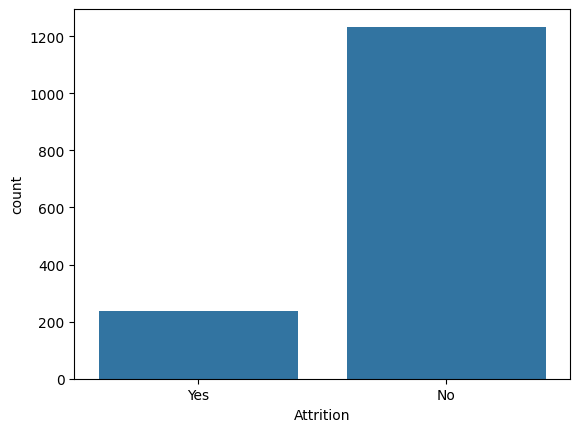

In [ ]:
sns.countplot(x=target_column, data=df)

#### Imbalance data set?
  - 두 개 target class 비중 차이가 있다. 독립 변수가 categorical 이 포함된 경우는 one-hot encoding을 진행한 뒤에 sampling 을 해야 한다.
  - "Yes" Attrition을 갖는 데이터들이 유의미한 데이터 분포와 특성을 갖는다면, 추가적인 sampling 없이 모델 학습이 잘 될 수 있다.
  - ML 학습시 cost-sensitive (class weight 등)을 활용할 수 있다.

##### 1. 데이터 기반 접근 방법
    - Sampling (over sampling 혹은 under sampling)
    (이번 실습에서는 combine sampling 중에서 SMOTEENN 활용)
    https://imbalanced-learn.org/stable/references/combine.html
##### 2. ML 알고리즘 기반 접근 방법
    - ML 알고리즘 활용 -> ML 학습 시에 class weight를 활용하여 cost-sensitive learning
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 2-3 Independent(독립) Data Explore

#### 1) Categorical Data Analysis

In [ ]:
# 분석전 target column을 categorical list에서 제외 - Attrition
list_categorical_columns.remove(target_column)

##### 불필요한 컬럼 제거

In [ ]:
df[list_categorical_columns].nunique().sort_values()

Over18                         1
Gender                         2
OverTime                       2
PerformanceRating              2
MaritalStatus                  3
BusinessTravel                 3
Department                     3
EnvironmentSatisfaction        4
JobSatisfaction                4
RelationshipSatisfaction       4
JobInvolvement                 4
StockOptionLevel               4
WorkLifeBalance                4
Education                      5
JobLevel                       5
EducationField                 6
JobRole                        9
EmployeeNumber              1470
dtype: int64

In [ ]:
# 불필요한 컬럼을 제거
# Over18은 1개 값만 갖으므로 제거
# EmployeeNumber는 고유한 id 값으로 제거
df = df.drop(["Over18", "EmployeeNumber"], axis=1).copy()
list_categorical_columns.remove("Over18")
list_categorical_columns.remove("EmployeeNumber")
print(list_categorical_columns)

['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']


In [ ]:
len(list_categorical_columns)

16

##### Column별 분포 확인

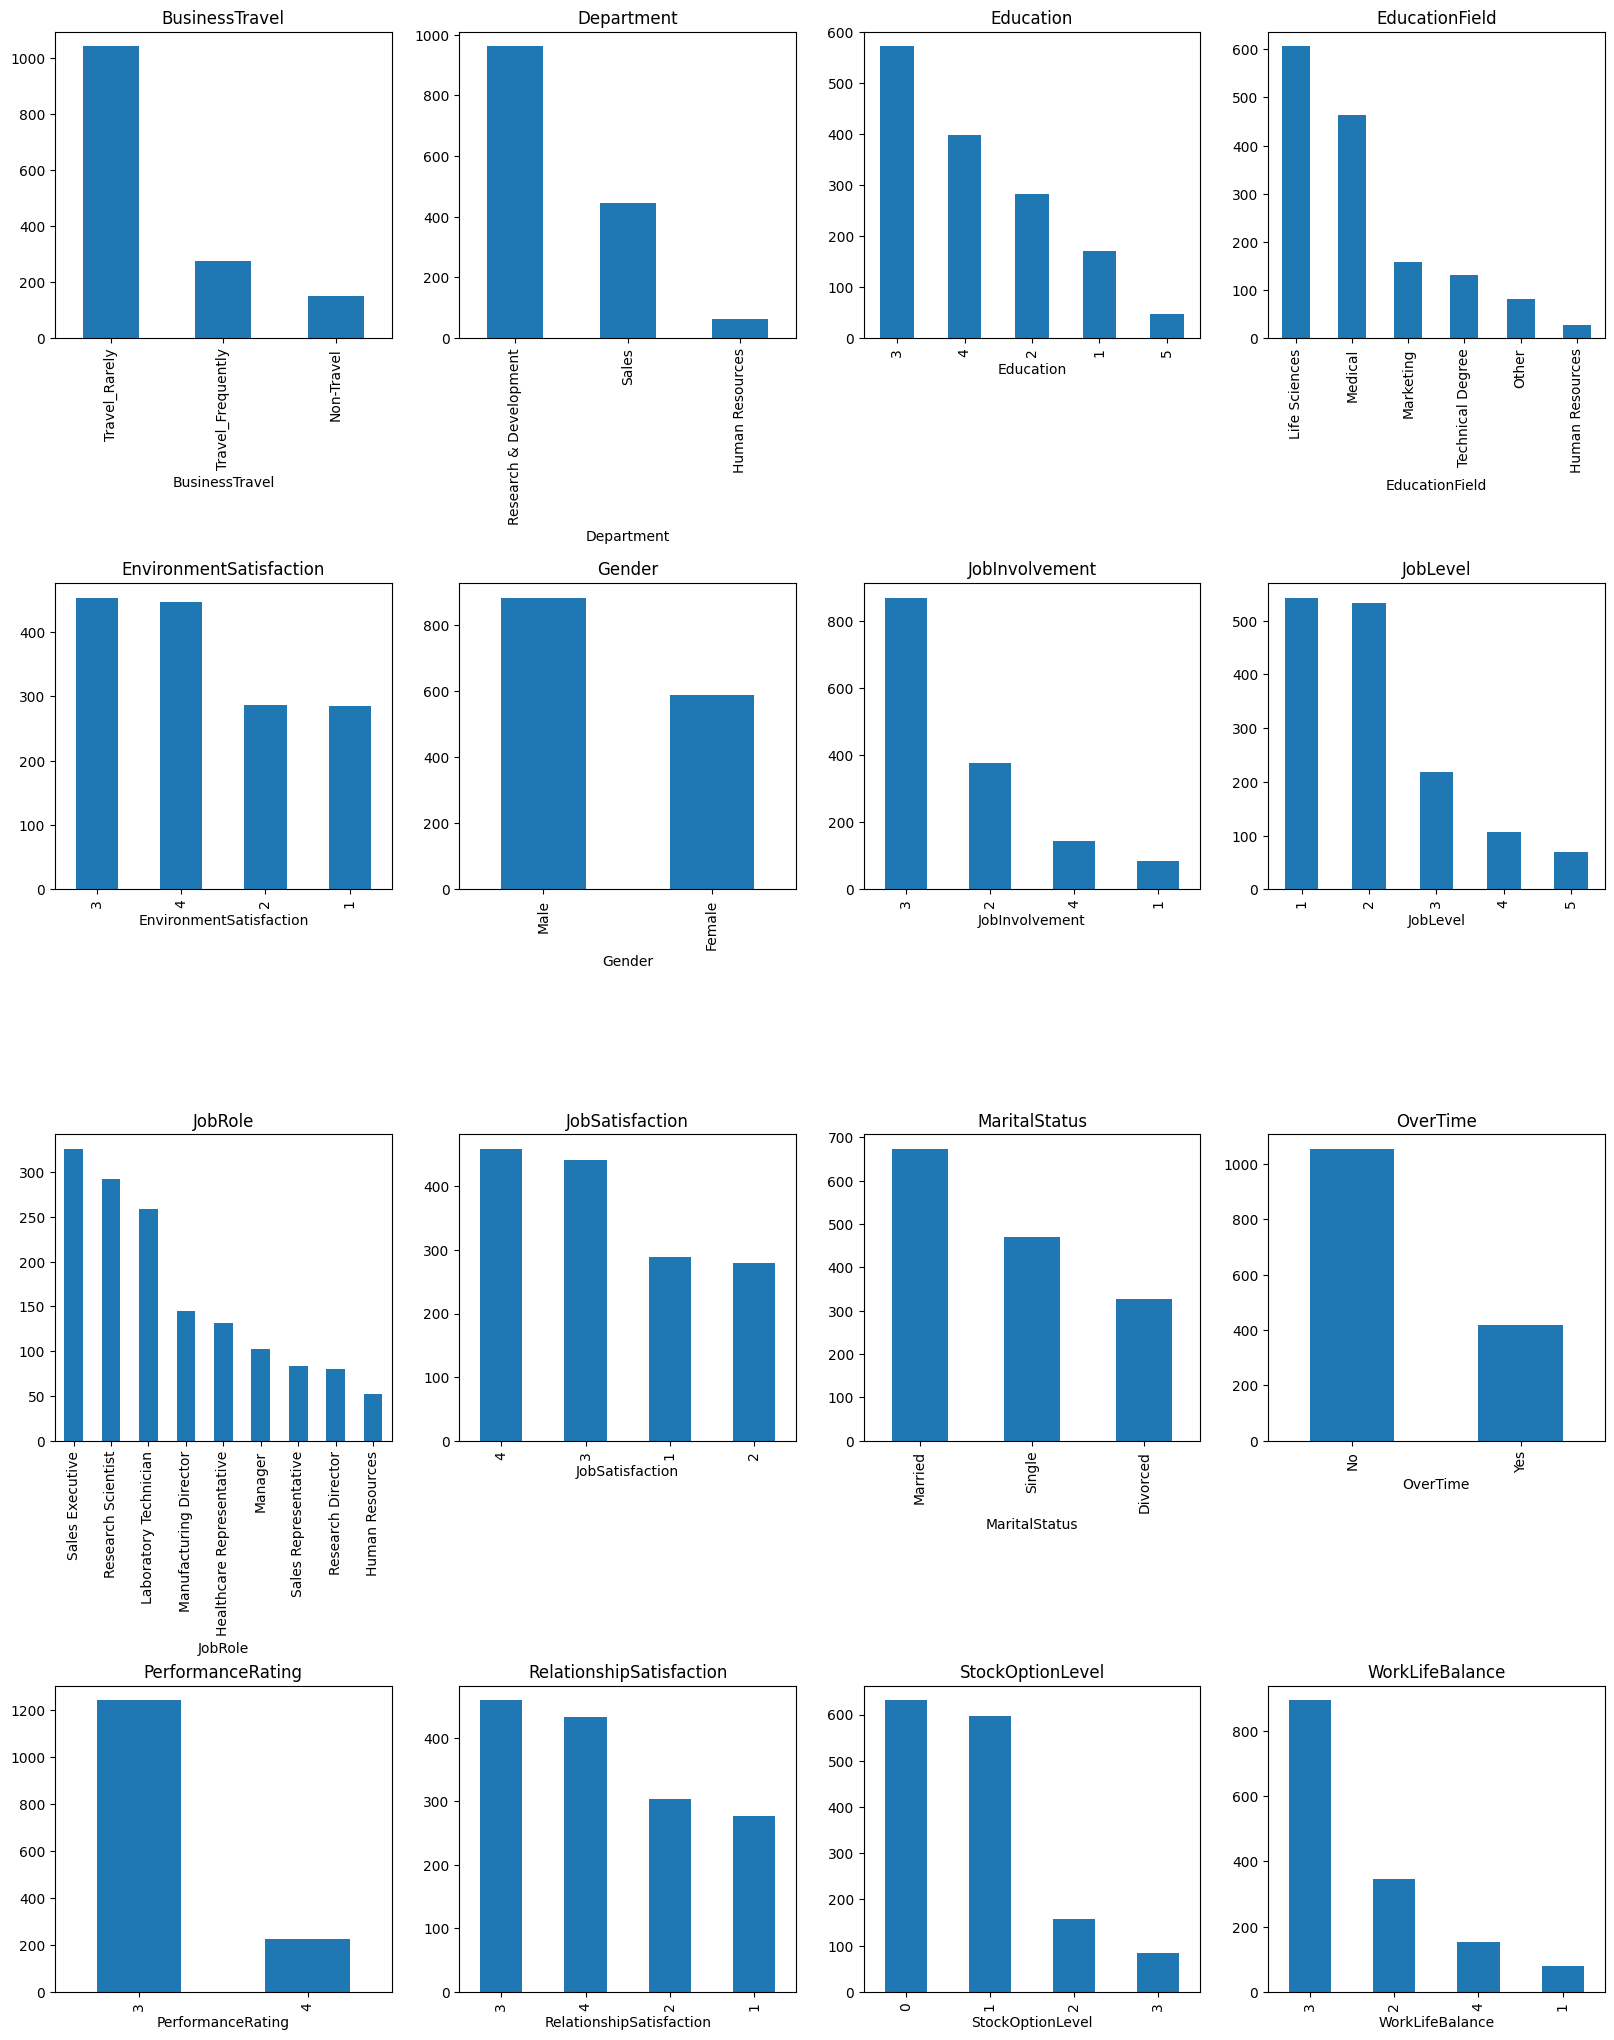

In [ ]:
# cateogircla column 별 분포 확인
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_columns:
    plt.subplot(4,4,x)
    x = x+1
    df[column_name].value_counts().plot(kind='bar')
    plt.title(column_name)
plt.show()

##### Target column과 categorical column 관계 분포 확인

<Figure size 3000x3000 with 0 Axes>

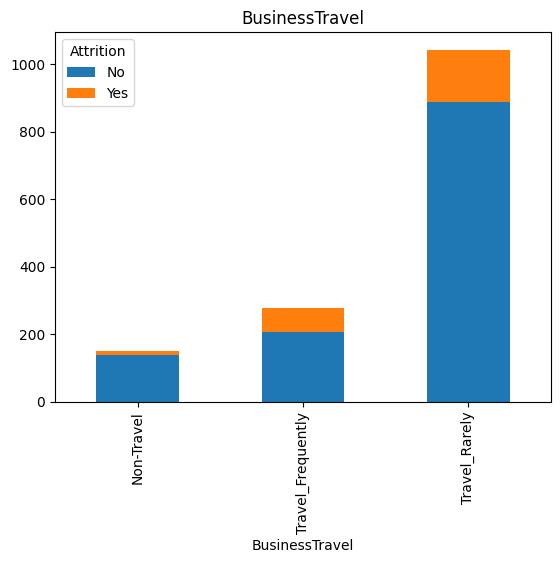

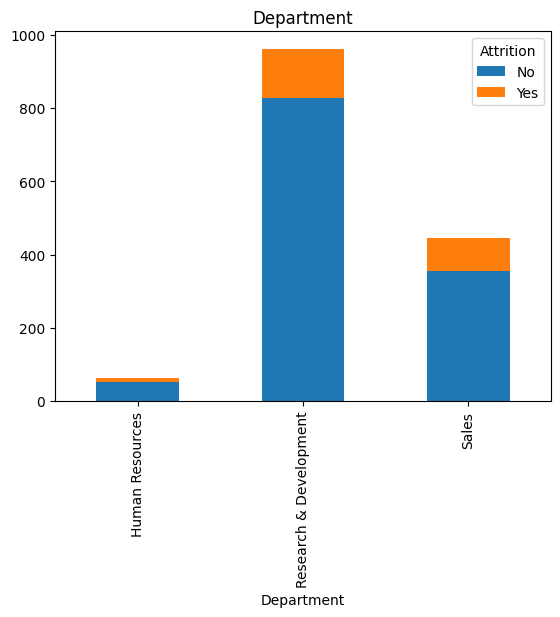

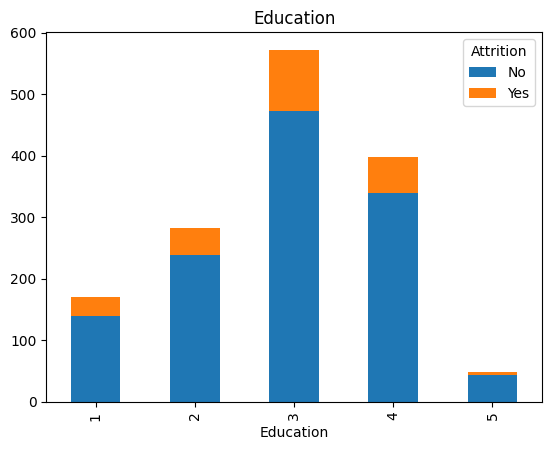

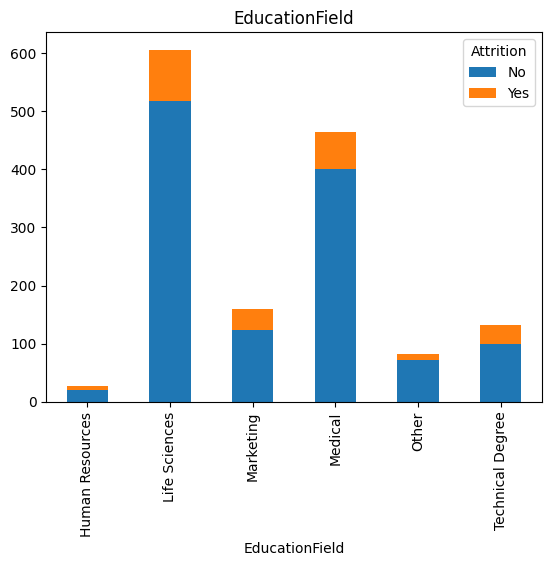

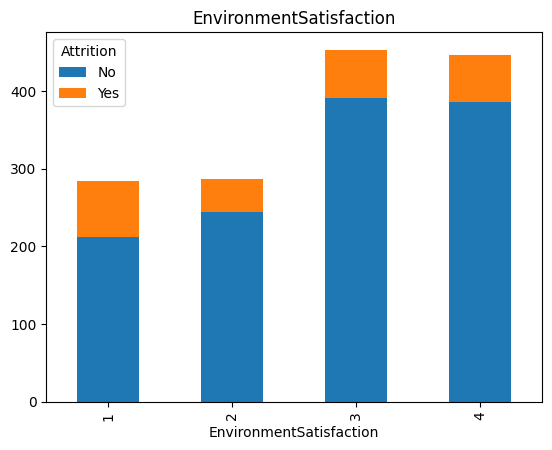

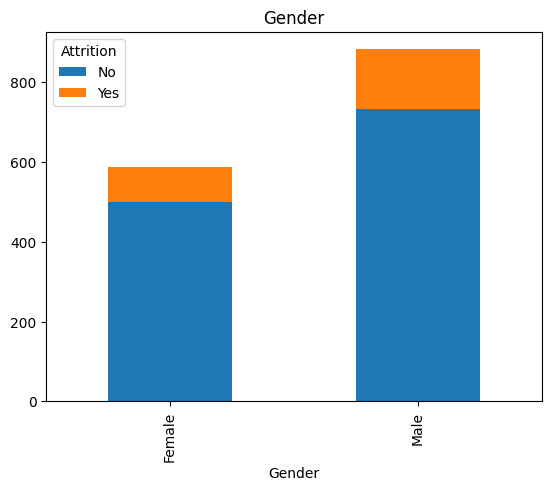

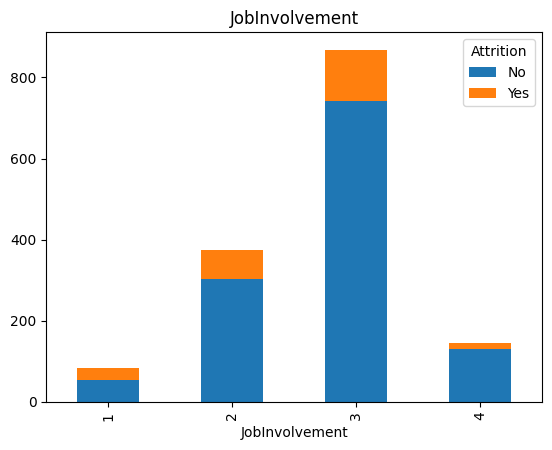

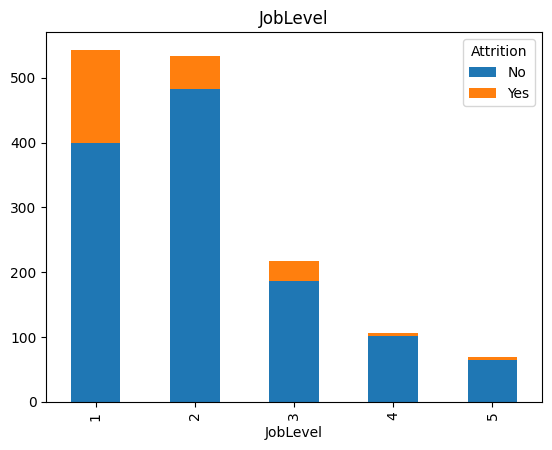

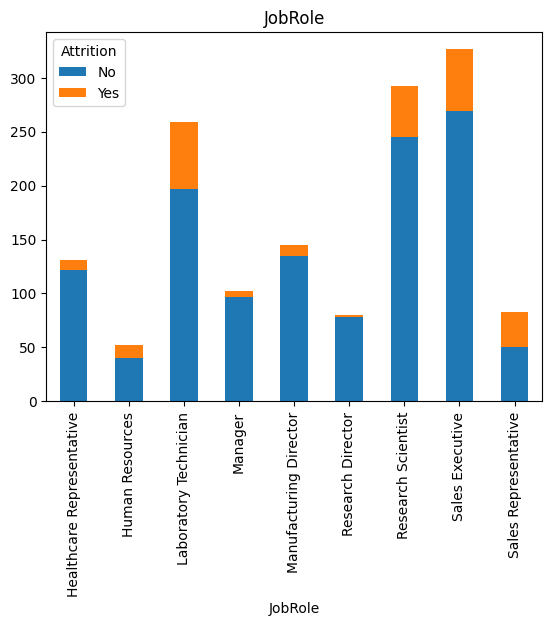

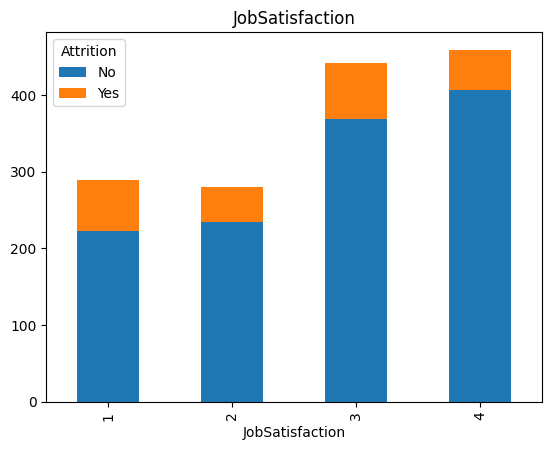

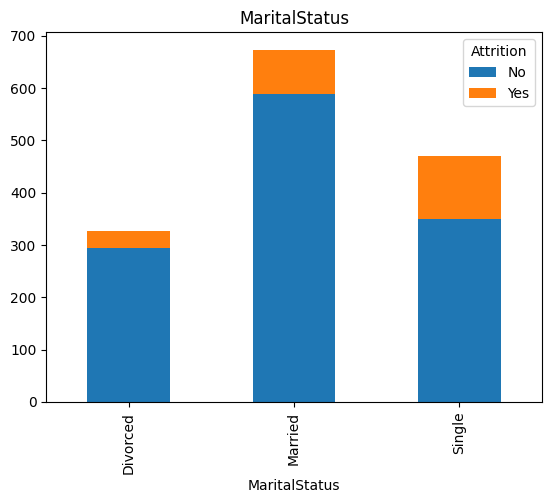

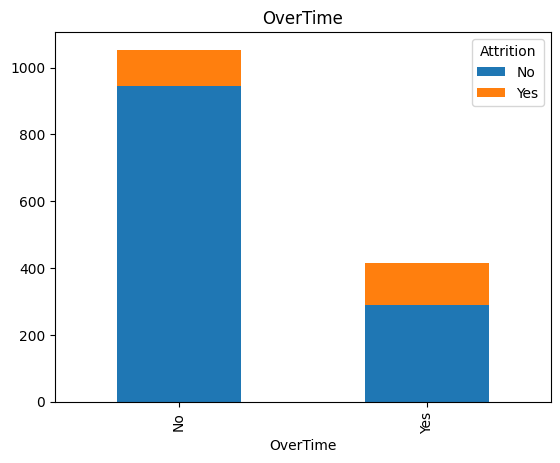

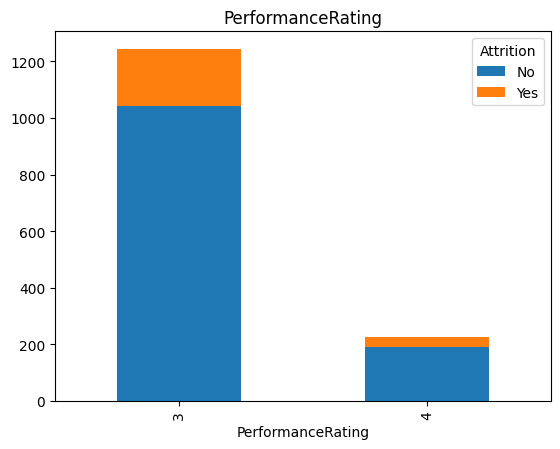

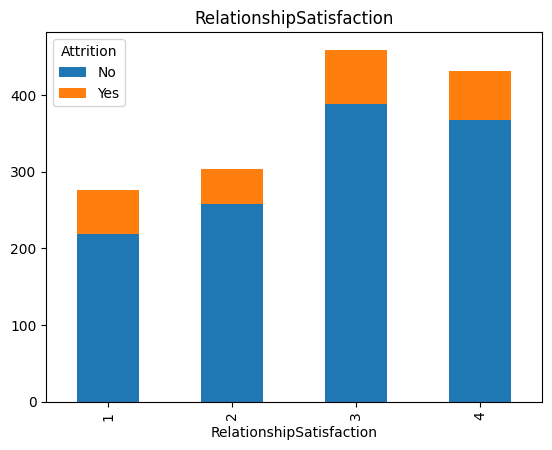

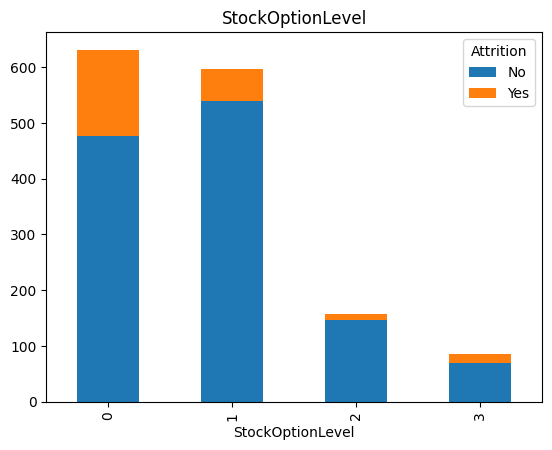

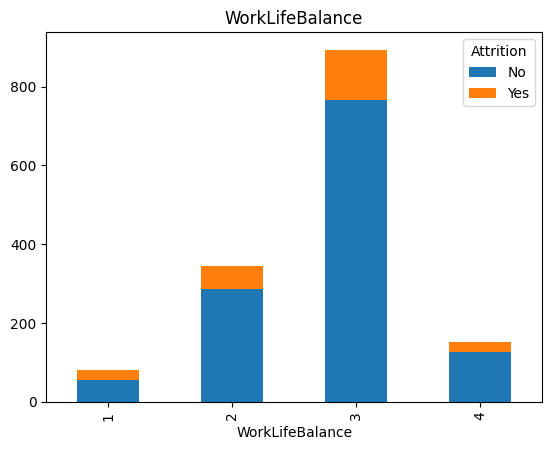

In [ ]:
# categorical column과 dependent data(target column) 분포 분석
plt.figure(figsize=(30,30))
x = 1
#plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_columns:
    x = x+1
    df.groupby([column_name, "Attrition"]).count()["Age"].unstack().plot(kind='bar', stacked=True)
    plt.title(column_name)
plt.show()

Target Column(Attribution)이 애초에 불균형하기 때문에 위와 같이 나타내면 데이터 분포를 이해하기 어려움. - 애초에 불균형 하기 때문에... yes가 적음

In [ ]:
# 비율로 나타가로줄(행, Attrition 여부)의 합계가 1(100%)**이 되도록 계산한 것입니다. - Attribution(퇴직율) 종속변수의 데이터 분포가 애초에 imbalance 했기 때문
# 즉, "퇴사한 사람끼리 모아보니 어떻더라", "남은 사람끼리 모아보니 어떻더라"

pd.crosstab(df[target_column], df["WorkLifeBalance"], normalize="index") # Attrition = Yes (퇴사자 그룹)의 분포, Attrition = No (재직자 그룹)의 분포

WorkLifeBalance         1         2         3         4
Attrition                                              
No               0.044607  0.231955  0.621249  0.102190
Yes              0.105485  0.244726  0.535865  0.113924

In [ ]:
# 워라밸 점수가 1점인 사람들은 얼마나 나가는가?", "3점인 사람들은 얼마나 나가는가? 퇴사율 분석에 더 직접적

pd.crosstab(df[target_column], df["WorkLifeBalance"], normalize="columns")

WorkLifeBalance       1         2         3         4
Attrition                                            
No               0.6875  0.831395  0.857783  0.823529
Yes              0.3125  0.168605  0.142217  0.176471

In [ ]:
# 각 퇴사 여부 그룹(No/Yes) 안에서 워라밸 점수 분포가 어떻게 되는가?

pd.crosstab(df["WorkLifeBalance"], df[target_column], normalize="columns")

Attrition              No       Yes
WorkLifeBalance                    
1                0.044607  0.105485
2                0.231955  0.244726
3                0.621249  0.535865
4                0.102190  0.113924

<Figure size 3000x3000 with 0 Axes>

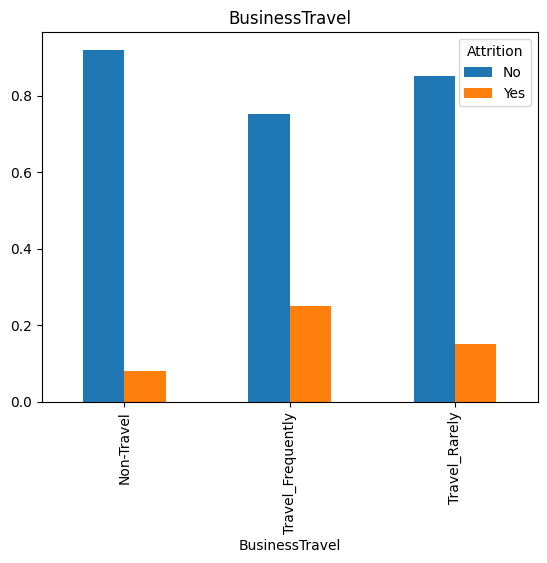

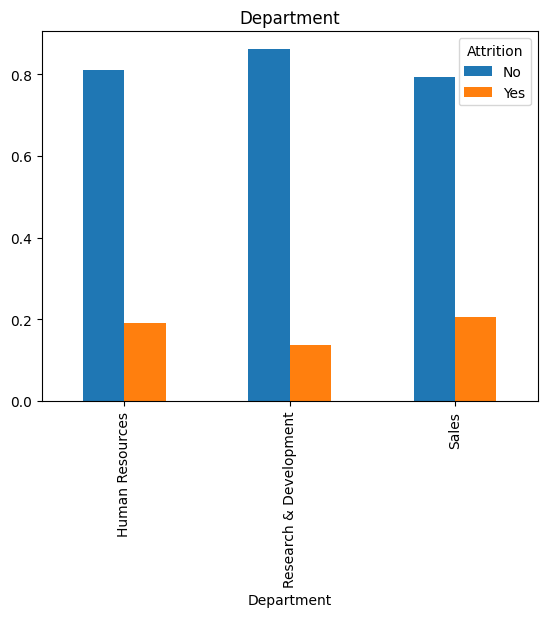

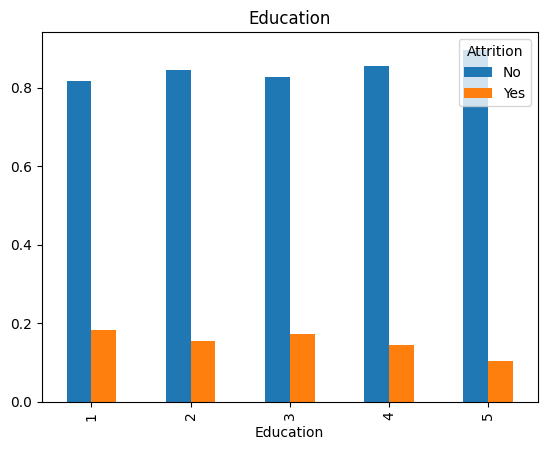

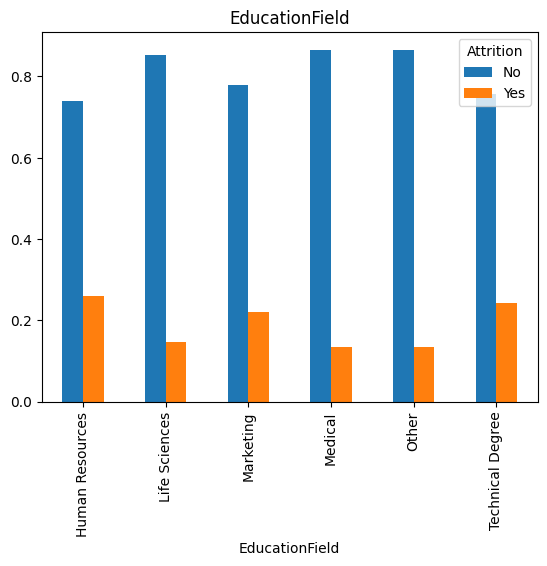

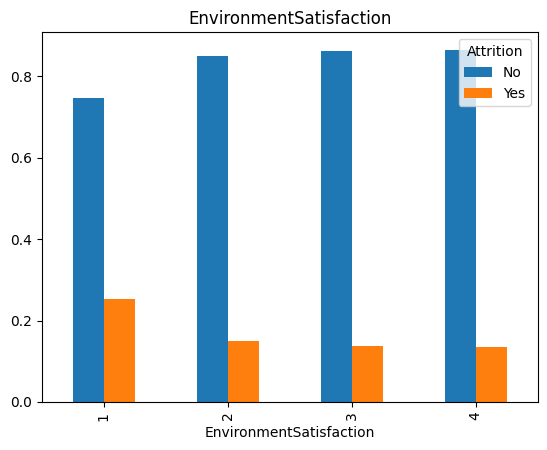

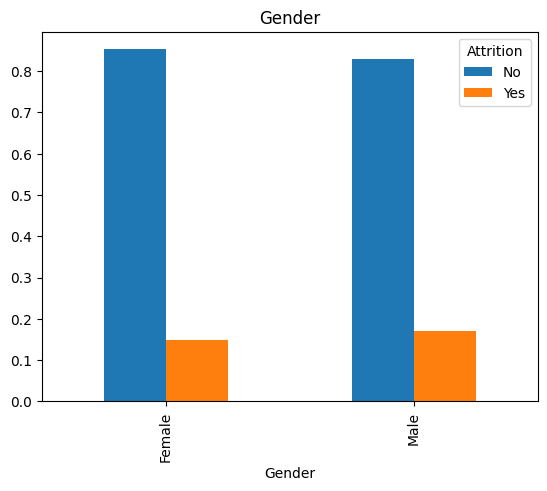

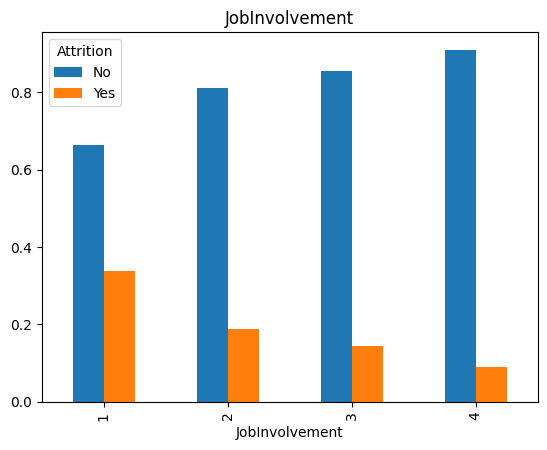

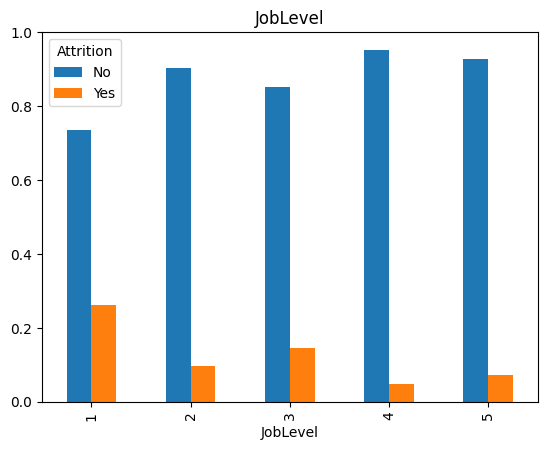

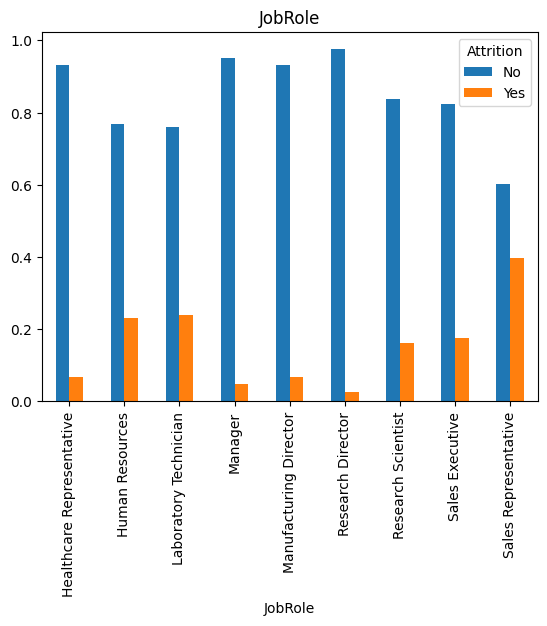

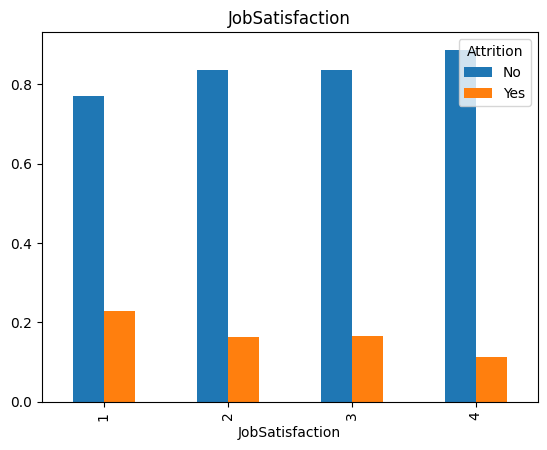

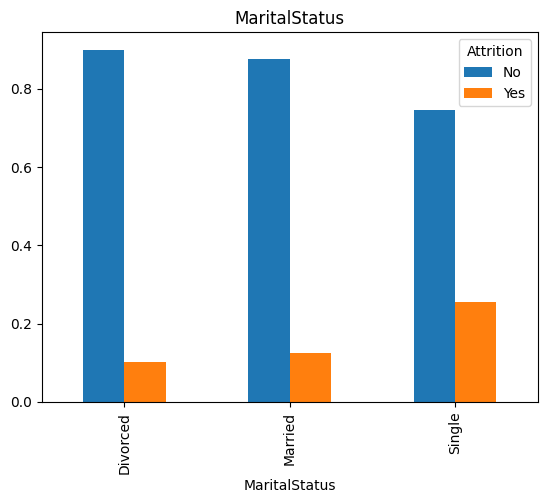

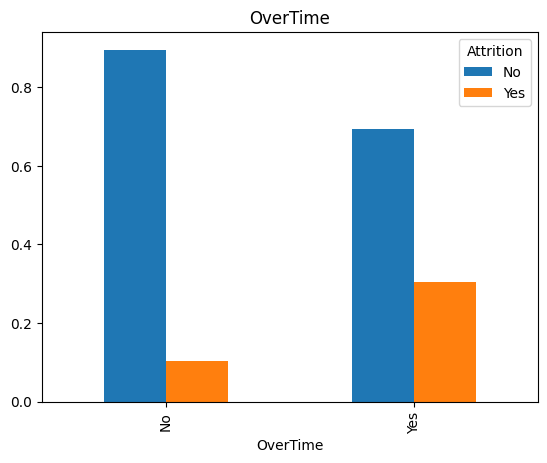

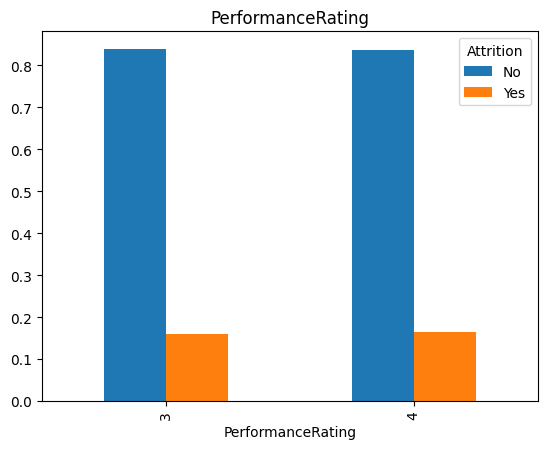

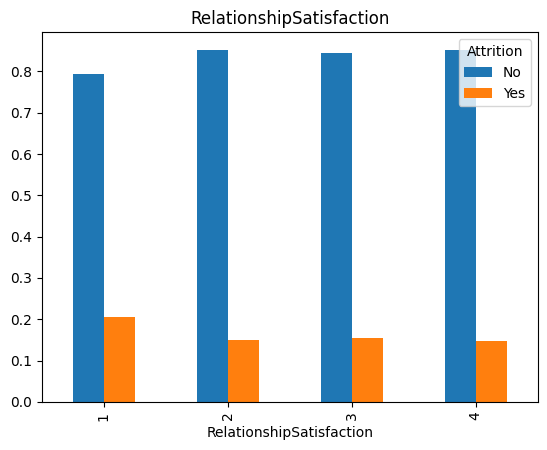

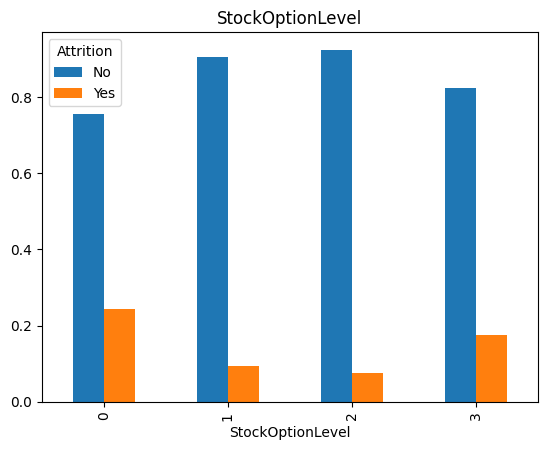

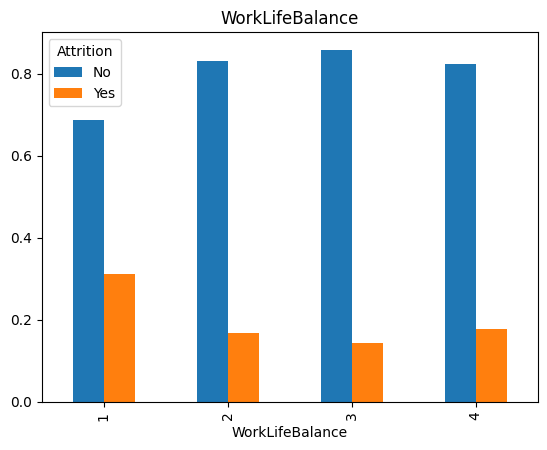

In [ ]:
# categorical column과 dependent data(target column) 분포 분석
plt.figure(figsize=(30,30))
x = 1
#plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_columns:
    x = x+1
    #df.groupby([column_name, "Attrition"]).count()["Age"].unstack().plot(kind='bar', stacked=True)
    #pd.crosstab(df[target_column], df[column_name], normalize="index").plot.bar()
    pd.crosstab(df[column_name], df[target_column], normalize="index").plot.bar()
    plt.title(column_name)
plt.show()

#pd.crosstab(df[target_column], df[column_name], normalize="index").plot.bar()

##### 카이제곱 검정 (chisqaure-test)
*   카이제곱 검정은 두 범주형 변수에 대한 분석 방법.
*   예를 들어, 성별에 따른 선호 영화 장르 비교 문제.
*   카이제곱 검정은 3가지 종류가 있으며, 데이터 수집 방법과 가설에 따라 나뉜다. 본 실습에서는 독립성 검정(test of independence)를 진행한다.
*   본 실습에서는 독립 변수중의 categorical column data와 Attrition 간의 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/카이제곱_검정



##### 카이제곱 검정 추가 설명 : 3가지 유형
1.   적합도 검정 (Goodness of fit)
  - 변수 1개
  - 기존에 알려준 기준이 존재하는 검정
  - 예시) 상자 안에 공 3개가 같은 비율로 알려져 있음. 공 100개를 뽑았을 때, 각 색의 비율이 구해짐. -> 기존에 알려진 공 비율 분포를 따르는지 검정
  - 귀무가설 : 변수 X의 관측분포와 기대 분포가 동일
  - 대립가설 : 변수 X의 관측분포와 기대 분포가 동일하지 않음

2.   독립성 검정 (Test of independence)
  - 변수 2개
  - 범주형 두 변수가 서로 연관되어 있는지 여부를 검정
  - 예시) 성별과 흡연 여부 관계를 알고 싶어서 200명을 추출하여 조사한 경우.
  - 귀무가설 : 변수 X와 Y는 서로 독립
  - 대립가설 : 변수 X와 Y는 서로 독립이 아님
3.   동질성 검정 (Test of Homogeneity)
  - 변수 2개
  - 범주형 두 변수의 관계를 알기 위한 검정은 아님
  - 각 그룹들이 동질한지 알고 싶은 검정
  - 예시) 남자와 여자 흡연율 차이가 있는지 흡연율을 조사한 후, 두 그룹의 흡연율이 같은지 여부를 검정
  - 귀무가설 : 각 그룹의 확률분포가 동일
  - 대립가설 : 각 그룹의 확률분포가 동일하지 않음




In [ ]:
list_meaningful_column_by_chi = []
for column_name in list_categorical_columns:
  statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column], df[column_name]))
  if pvalue <= 0.05:
    list_meaningful_column_by_chi.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all categorical columns : ", len(list_categorical_columns))
print("selected columns by chi : ", len(list_meaningful_column_by_chi), list_meaningful_column_by_chi)

BusinessTravel ,  24.182413685655174 ,  5.608614476449931e-06
Department ,  10.79600732241067 ,  0.004525606574479633
Education ,  3.0739613982367193 ,  0.5455253376565949
EducationField ,  16.024674119585423 ,  0.006773980139025222
EnvironmentSatisfaction ,  22.503881435842295 ,  5.1234689062894205e-05
Gender ,  1.1169671241970975 ,  0.29057244902890855
JobInvolvement ,  28.492021234659283 ,  2.8631806367134195e-06
JobLevel ,  72.52901310667391 ,  6.634684715458909e-15
JobRole ,  86.19025367670434 ,  2.752481638050657e-15
JobSatisfaction ,  17.505077010348 ,  0.0005563004510387556
MaritalStatus ,  46.163676540848705 ,  9.45551106034083e-11
OverTime ,  87.56429365828768 ,  8.15842372153832e-21
PerformanceRating ,  0.00015475439428271534 ,  0.9900745465934576
RelationshipSatisfaction ,  5.241067859713708 ,  0.15497244371052626
StockOptionLevel ,  60.59830108612225 ,  4.379390336108354e-13
WorkLifeBalance ,  16.3250970916474 ,  0.0009725698845348824
all categorical columns :  16
selected

##### Insight
1.   Attrition(종속 변수)와 유의미한 관계를 갖지 않는 categorical data가 확인됨
2.   feature selection 및 model optimization을 위해 1번에서 얻은 결과를 활용



#### 2) Numeric Data Analysis

##### 불필요한 컬럼 제거

In [ ]:
df[list_numeric_columns].nunique().sort_values()

EmployeeCount                 1
StandardHours                 1
TrainingTimesLastYear         7
NumCompaniesWorked           10
PercentSalaryHike            15
YearsSinceLastPromotion      16
YearsWithCurrManager         18
YearsInCurrentRole           19
DistanceFromHome             29
YearsAtCompany               37
TotalWorkingYears            40
Age                          43
HourlyRate                   71
DailyRate                   886
MonthlyIncome              1349
MonthlyRate                1427
dtype: int64

In [ ]:
df["MonthlyRate"]

0       19479
1       24907
2        2396
3       23159
4       16632
        ...  
1465    12290
1466    21457
1467     5174
1468    13243
1469    10228
Name: MonthlyRate, Length: 1470, dtype: int64

In [ ]:
# 불필요한 컬럼을 제거
# unique number가 1인 것들 제거
df = df.drop(["EmployeeCount", "StandardHours"], axis=1).copy()
list_numeric_columns.remove("EmployeeCount")
list_numeric_columns.remove("StandardHours")
print(list_numeric_columns)

['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


##### Column별 분포 확인

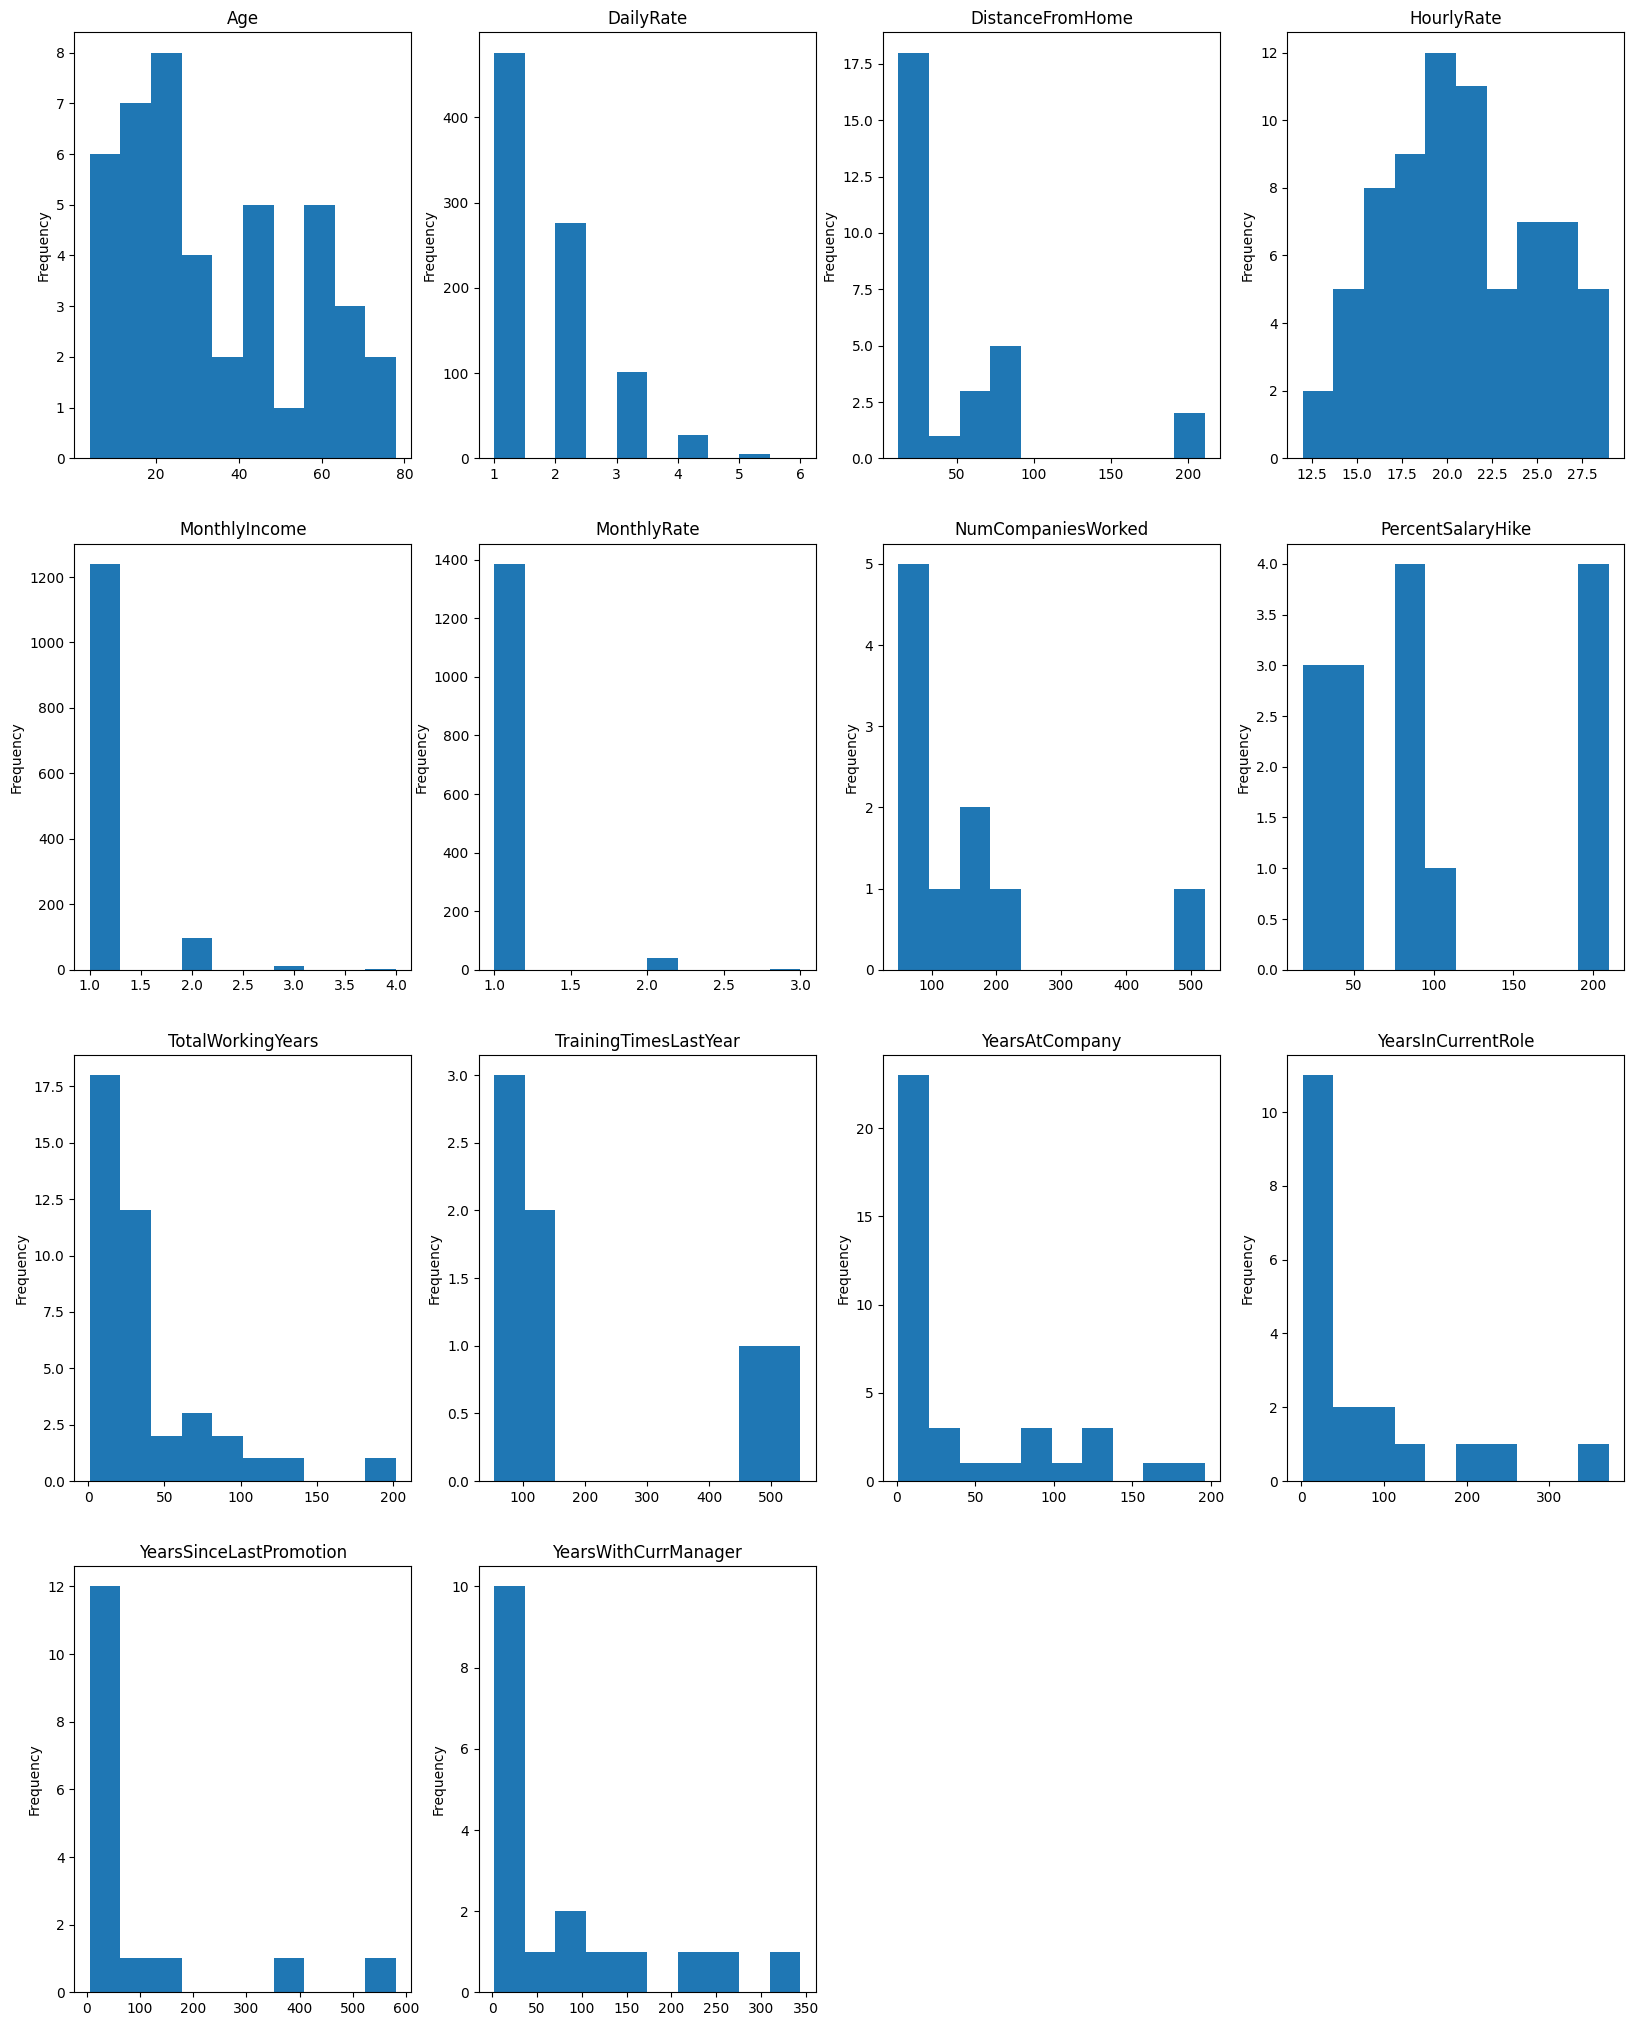

In [ ]:
# numeric column 별 분포 확인
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(4,4,x)
    x = x+1
    df[column_name].value_counts().plot(kind='hist')
    plt.title(column_name)
plt.show()

<Axes: xlabel='MonthlyIncome', ylabel='Age'>

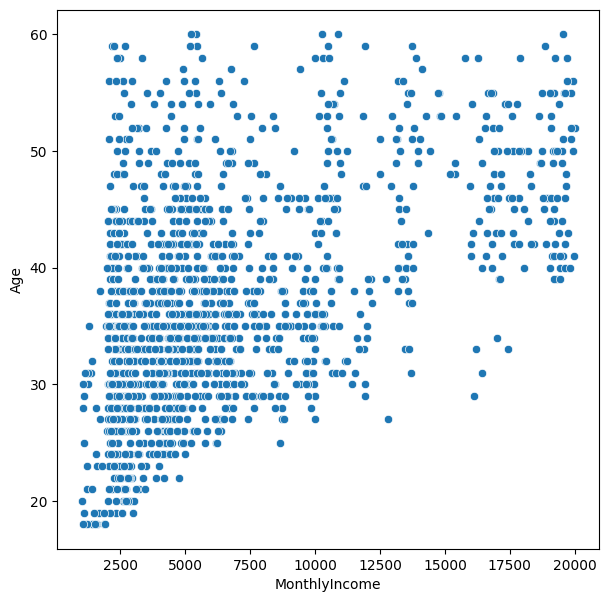

In [ ]:
# scatter plot 1 - 수치형 데이터도 상관관계 파악 필요
plt.figure(figsize=(7,7))
sns.scatterplot(data=df, x="MonthlyIncome", y="Age")

<Axes: xlabel='TotalWorkingYears', ylabel='MonthlyIncome'>

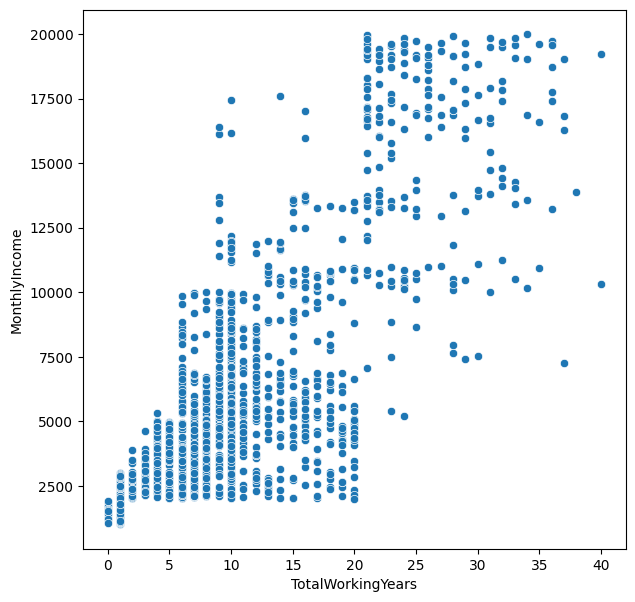

In [ ]:
# scatter plot 2
plt.figure(figsize=(7,7))
sns.scatterplot(data=df, x="TotalWorkingYears", y="MonthlyIncome")

<Axes: xlabel='PerformanceRating', ylabel='PercentSalaryHike'>

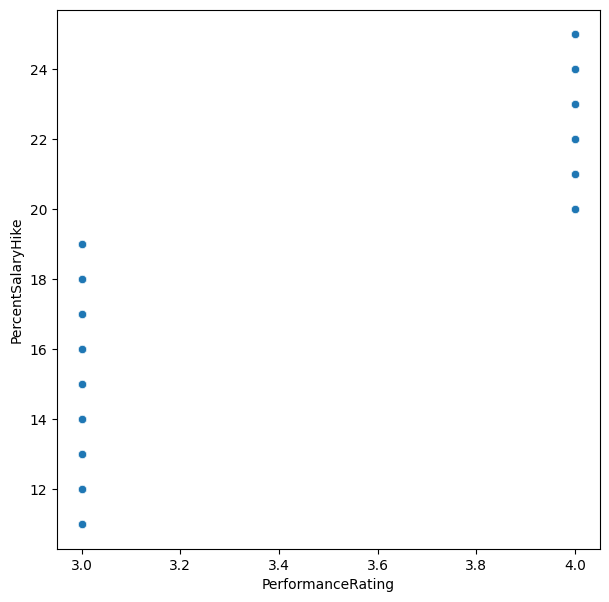

In [ ]:
# scatter plot 3
plt.figure(figsize=(7,7))
sns.scatterplot(data=df, x="PerformanceRating", y="PercentSalaryHike")

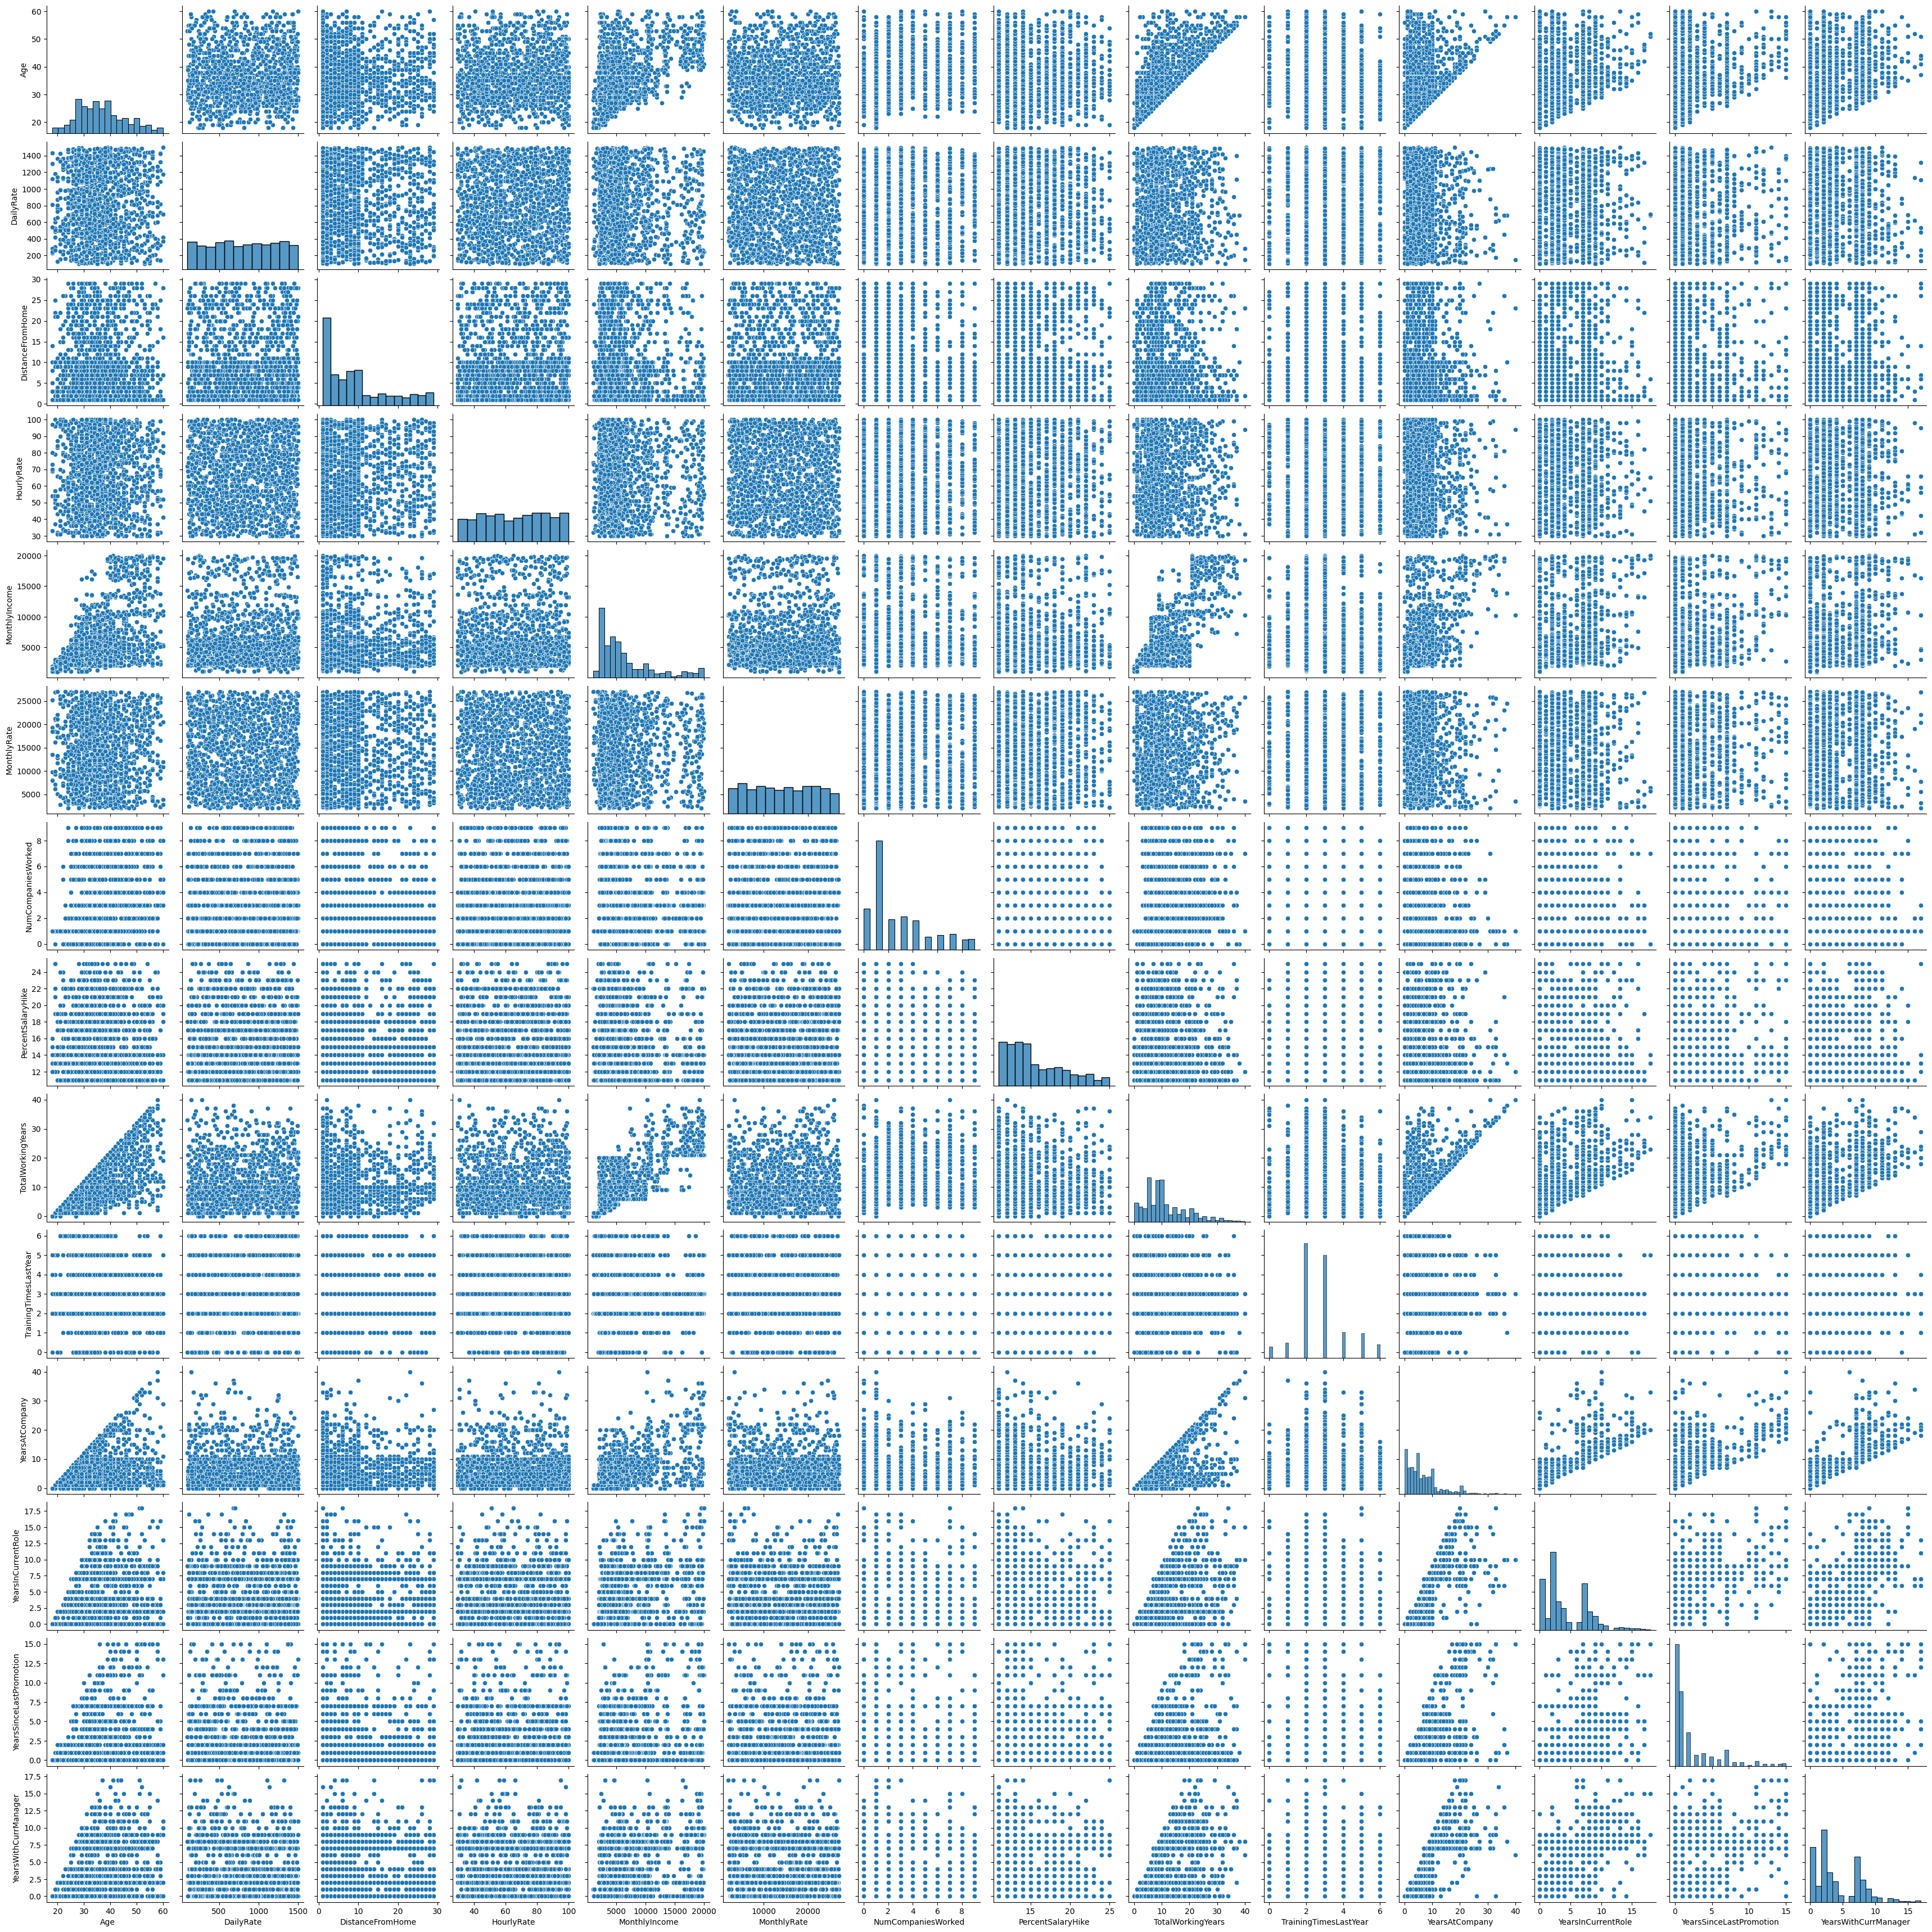

In [ ]:
sns.pairplot(df[list_numeric_columns])

##### Correlation Analysis

<Axes: >

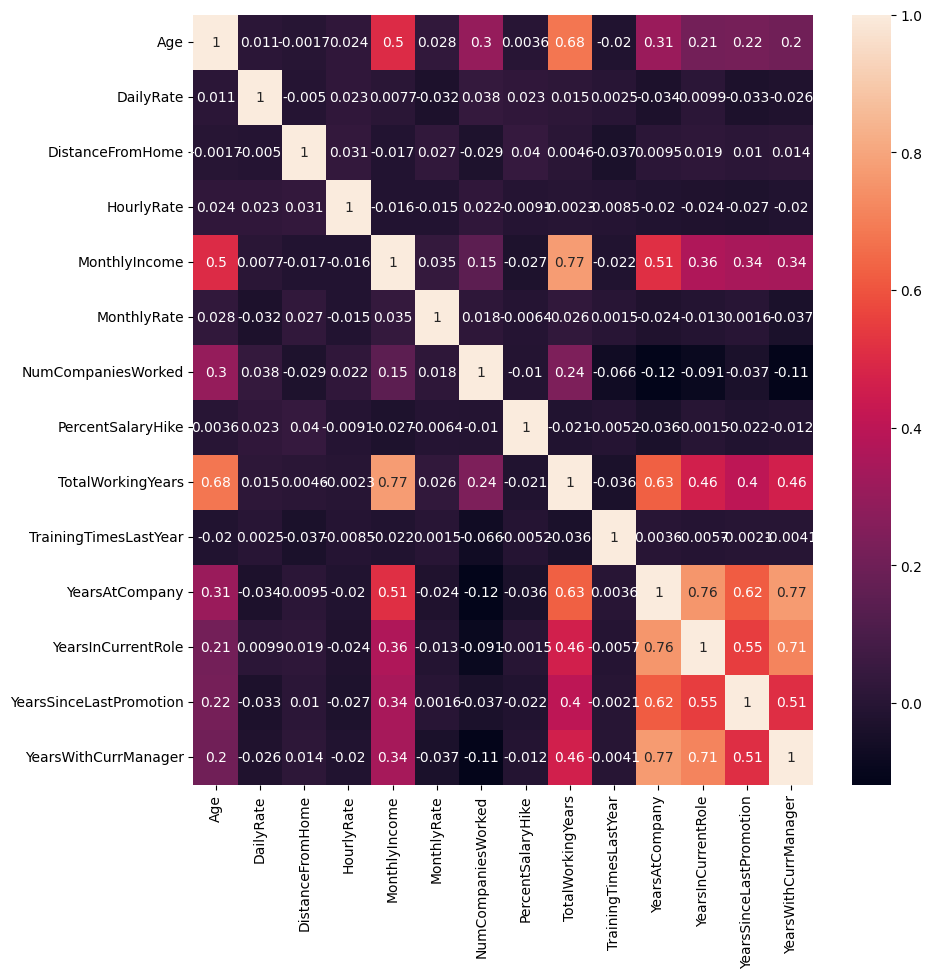

In [ ]:
# 상관관계 수치적 피약 (Correlation)

df_corr = df[list_numeric_columns].corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_corr, annot=True)

##### VIF Analysis
-   일반적으로는는 10이상인인 경우 다중공선성이이 있다고 가정
-   high correlation 컬럼을 제거하기 전에 한 번 더 검정을 진행 (doublecheck, 개인의 판단에 따라서 진행하지 않아도됨)

In [ ]:
def caculate_vif(df_target):
  vif = pd.DataFrame()
  vif['VIF_Factor'] = [variance_inflation_factor(df_target.values, i) for i in range(df_target.shape[1])]
  vif['Feature'] = df_target.columns
  return vif

df_vif = df[list_numeric_columns].copy()

In [ ]:
caculate_vif(df_vif)

VIF_Factor                  Feature
0    25.496860                      Age
1     4.721572                DailyRate
2     2.271398         DistanceFromHome
3     9.767720               HourlyRate
4     7.286833            MonthlyIncome
5     4.737393              MonthlyRate
6     2.675998       NumCompaniesWorked
7    13.578688        PercentSalaryHike
8    13.311109        TotalWorkingYears
9     5.302141    TrainingTimesLastYear
10   10.485271           YearsAtCompany
11    6.342271       YearsInCurrentRole
12    2.437206  YearsSinceLastPromotion
13    6.380952     YearsWithCurrManager

In [ ]:
caculate_vif(df_vif.drop(["TotalWorkingYears","Age","PercentSalaryHike"],axis=1))

VIF_Factor                  Feature
0     4.365355                DailyRate
1     2.205211         DistanceFromHome
2     7.507071               HourlyRate
3     4.212697            MonthlyIncome
4     4.343285              MonthlyRate
5     2.263575       NumCompaniesWorked
6     4.710238    TrainingTimesLastYear
7     9.432830           YearsAtCompany
8     6.322306       YearsInCurrentRole
9     2.435655  YearsSinceLastPromotion
10    6.346938     YearsWithCurrManager

In [ ]:
list_numeric_feature_by_vif = list_numeric_columns.copy()
list_numeric_feature_by_vif.remove("TotalWorkingYears")
list_numeric_feature_by_vif.remove("Age")
list_numeric_feature_by_vif.remove("PercentSalaryHike")

list_numeric_feature_by_vif

['DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

##### Target Column과 numeric Column 관계 분포 확인

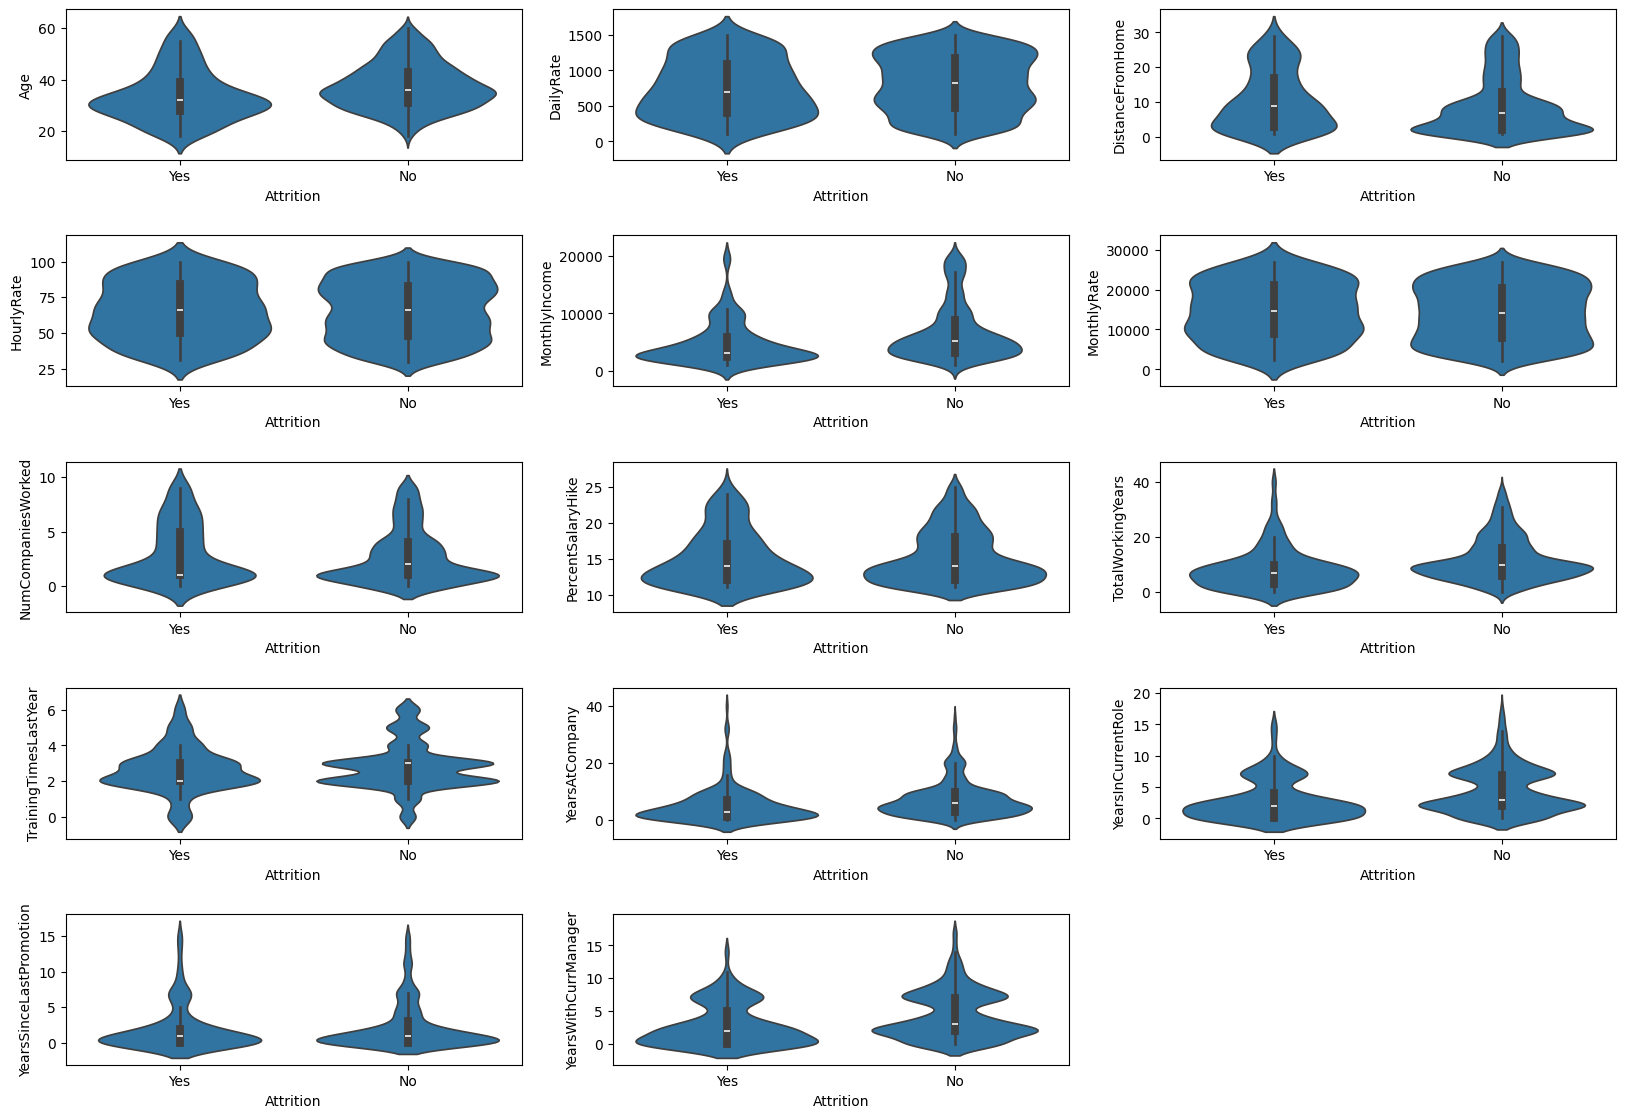

In [ ]:
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(9,3,x)
    x = x + 1
    sns.violinplot(data=df,x=target_column,y=column_name)
plt.show()

##### 일원분산분석 (ANOVA)
*   카테고리별 numeric data 분포 차이를 검증
*   전제 : 정규성, 등분산성, 독립성 (만족하지 않으면 해당 검정을 신뢰할 수 없음)
*   본 실습에서는 Attrition 에 따른 numeric column data 분포 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/분산_분석#일원분산분석(one-way_ANOVA)





정규성 검정
*   귀무가설 : 모집단의 분포는 정규 분포이다
*   검정 방법 : Shpiro-Wilks Test, qqplot
*   p-value < 0.05이면, 귀무가설 기각 (기각하지 못하여야 정규성을 만족)

In [ ]:
# shapiro wilk test 검정
# 귀무가설 : 해당 데이터는 정규분포이다.
# pvalue <0.05 이면 귀무가설 기각
for column_name in list_numeric_columns:
  statistic, pvalue = stats.shapiro(df[column_name])
  if pvalue >= 0.05:
    print(column_name)
print("end")

end


Box-Cox Transformation
*   Box 와 Cox는 적절한 비선형 변환으로 정규성을 만족시킬 수 있다고 주장
*   람다 값에 따라서 변수 변환이 결정되는 방식
*   장점 : 반응 변수의 정규성을 만족시킬 수 있음
*   단점 : 해석이 어려움
*   https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation


In [ ]:
# boxcox transformation
for column_name in list_numeric_columns:
  condition = (df[column_name] > 0)
  statistic, pvalue = stats.shapiro(stats.boxcox(df.loc[condition, column_name])[0])
  if pvalue >= 0.05:
    print(column_name)
print("end")

end


In [ ]:
# log transfomration
for column_name in list_numeric_columns:
  condition = (df[column_name] > 0)
  statistic, pvalue = stats.shapiro(np.log(df.loc[condition, column_name]))
  if pvalue >= 0.05:
    print(column_name)
print("end")

end


##### 크루스칼 왈리스 검정 Kruskall-Wallis test (비모수 검정)
*   비모수 검정이기 때문에 정규성/등분산성을 만족하지 않아도됨
*   단, 비모수 검정이기 때문에 검정 결과 신뢰도가 모수 검정보다 떨어짐

In [ ]:
# kruskall 검정
list_meaningful_column_by_kruskall = []

for column_name in list_numeric_columns:
  list_by_value = []
  for value in df[target_column].dropna().unique():
      df_tmp = df[df[target_column] == value][column_name].dropna()
      list_by_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all categorical columns : ", len(list_numeric_columns))
print("selected columns by kruskal : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

Age ,  43.06268844023747 ,  5.3013684961038114e-11
DailyRate ,  4.767706640276287 ,  0.02899842966260463
DistanceFromHome ,  9.225723965000004 ,  0.002386383151703113
HourlyRate ,  0.06579158284658387 ,  0.7975657845068993
MonthlyIncome ,  57.768241263784475 ,  2.948926498830519e-14
MonthlyRate ,  0.3419741493810883 ,  0.5586919160154533
NumCompaniesWorked ,  1.3669853624354948 ,  0.24233051615850376
PercentSalaryHike ,  0.8190089297863566 ,  0.3654700908743005
TotalWorkingYears ,  58.175049815828345 ,  2.3980118249072023e-14
TrainingTimesLastYear ,  3.9351850554126635 ,  0.04728593768607503
YearsAtCompany ,  53.26510705772158 ,  2.9143753542698205e-13
YearsInCurrentRole ,  47.925653386167035 ,  4.426912787258302e-12
YearsSinceLastPromotion ,  4.168984320865666 ,  0.04117047318275827
YearsWithCurrManager ,  45.17087528790509 ,  1.8057061514626796e-11
all categorical columns :  14
selected columns by kruskal :  10 ['Age', 'DailyRate', 'DistanceFromHome', 'MonthlyIncome', 'TotalWorkingYe

In [ ]:
# kruskall 검정과 vif 분석에서 Target Column과 유의미한 관계를 갖는 것들의 교집합
list_meaningful_vif_and_kruskall = list(np.intersect1d(list_numeric_feature_by_vif,list_meaningful_column_by_kruskall))
print(len(list_meaningful_vif_and_kruskall))

8


In [ ]:
list_meaningful_vif_and_kruskall

[np.str_('DailyRate'),
 np.str_('DistanceFromHome'),
 np.str_('MonthlyIncome'),
 np.str_('TrainingTimesLastYear'),
 np.str_('YearsAtCompany'),
 np.str_('YearsInCurrentRole'),
 np.str_('YearsSinceLastPromotion'),
 np.str_('YearsWithCurrManager')]

##### Insight
1.   Attrition(종속 변수)와 유의미한 관계를 갖지 않는 numerical data가 확인됨
2.   feature selection 및 model optimization을 위해 1번에서 얻은 결과를 활용
3.   numercial data 간의 다중공선성이 의심되는 변수들이 있음
4.   kruskall 검정과 vif 분석에서 문제가 없는 numerial data는 총 8개



## 3. Data Processing 2

### 3-1 Missing Values

In [ ]:
df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

### 3-2 Feature Transformation

In [ ]:
Y = df[target_column]
X = df.drop([target_column], axis=1)

In [ ]:
Y

0       Yes
1        No
2       Yes
3        No
4        No
       ... 
1465     No
1466     No
1467     No
1468     No
1469     No
Name: Attrition, Length: 1470, dtype: object

##### Label Encoding

In [ ]:
le_encoder = LabelEncoder()
Y_encoded = le_encoder.fit_transform(Y)
Y_encoded

array([1, 0, 1, ..., 0, 0, 0])

##### Feature Selection

In [ ]:
X_fs = df[list_meaningful_column_by_chi + list_meaningful_vif_and_kruskall] # list_meaningful_column_by_chi (categorical), list_meaningful_vif_and_kruskall (numerical)
X_fs

BusinessTravel              Department EducationField  \
0         Travel_Rarely                   Sales  Life Sciences   
1     Travel_Frequently  Research & Development  Life Sciences   
2         Travel_Rarely  Research & Development          Other   
3     Travel_Frequently  Research & Development  Life Sciences   
4         Travel_Rarely  Research & Development        Medical   
...                 ...                     ...            ...   
1465  Travel_Frequently  Research & Development        Medical   
1466      Travel_Rarely  Research & Development        Medical   
1467      Travel_Rarely  Research & Development  Life Sciences   
1468  Travel_Frequently                   Sales        Medical   
1469      Travel_Rarely  Research & Development        Medical   

     EnvironmentSatisfaction JobInvolvement JobLevel  \
0                          2              3        2   
1                          3              2        2   
2                          4              2        1   
3                          4              3        1   
4                          1              3        1   
...                      ...            ...      ...   
1465                       3              4        2   
1466                       4              2        3   
1467                       2              4        2   
1468                       4              2        2   
1469                       2              4        2   

                        JobRole JobSatisfaction MaritalStatus OverTime  \
0               Sales Executive               4        Single      Yes   
1            Research Scientist               2       Married       No   
2         Laboratory Technician               3        Single      Yes   
3            Research Scientist               3       Married      Yes   
4         Laboratory Technician               2       Married       No   
...                         ...             ...           ...      ...   
1465      Laboratory Technician               4       Married       No   
1466  Healthcare Representative               1       Married       No   
1467     Manufacturing Director               2       Married      Yes   
1468            Sales Executive               2       Married       No   
1469      Laboratory Technician               3       Married       No   

     StockOptionLevel WorkLifeBalance  DailyRate  DistanceFromHome  \
0                   0               1       1102                 1   
1                   1               3        279                 8   
2                   0               3       1373                 2   
3                   0               3       1392                 3   
4                   1               3        591                 2   
...               ...             ...        ...               ...   
1465                1               3        884                23   
1466                1               3        613                 6   
1467                1               3        155                 4   
1468                0               2       1023                 2   
1469                0               4        628                 8   

      MonthlyIncome  TrainingTimesLastYear  YearsAtCompany  \
0              5993                      0               6   
1              5130                      3              10   
2              2090                      3               0   
3              2909                      3               8   
4              3468                      3               2   
...             ...                    ...             ...   
1465           2571                      3               5   
1466           9991                      5               7   
1467           6142                      0               6   
1468           5390                      3               9   
1469           4404                      3               4   

      YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrMana

##### One-hot Encoding for categorical column data

In [ ]:
X_base = pd.get_dummies(X) # Attarition (Target 변수)
X_fs_final = pd.get_dummies(X_fs) # Feature Selection Data

In [ ]:
X_fs_final

DailyRate  DistanceFromHome  MonthlyIncome  TrainingTimesLastYear  \
0          1102                 1           5993                      0   
1           279                 8           5130                      3   
2          1373                 2           2090                      3   
3          1392                 3           2909                      3   
4           591                 2           3468                      3   
...         ...               ...            ...                    ...   
1465        884                23           2571                      3   
1466        613                 6           9991                      5   
1467        155                 4           6142                      0   
1468       1023                 2           5390                      3   
1469        628                 8           4404                      3   

      YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
0                  6                   4                        0   
1                 10                   7                        1   
2                  0                   0                        0   
3                  8                   7                        3   
4                  2                   2                        2   
...              ...                 ...                      ...   
1465               5                   2                        0   
1466               7                   7                        1   
1467               6                   2                        0   
1468               9                   6                        0   
1469               4                   3                        1   

      YearsWithCurrManager  BusinessTravel_Non-Travel  \
0                        5                      False   
1                        7                      False   
2                        0                      False   
3                        0                      False   
4                        2                      False   
...                    ...                        ...   
1465                     3                      False   
1466                     7                      False   
1467                     3                      False   
1468                     8                      False   
1469                     2                      False   

      BusinessTravel_Travel_Frequently  ...  OverTime_No  OverTime_Yes  \
0                                False  ...        False          True   
1                                 True  ...         True         False   
2                                False  ...        False          True   
3                                 True  ...        False          True   
4                                False  ...         True         False   
...                                ...  ...          ...           ...   
1465                              True  ...         True         False   
1466                             False  ...         True         False   
1467                             False  ...        False          True   
1468                              True  ...         True         False   
1469                             False  ...         True         False   

      StockOptionLevel_0  StockOptionLevel_1  StockOptionLevel_2  \
0                   True               False               False   
1                  False                True               False   
2                   True               False               False   
3                   True               False               False   
4                  False                True               False   
...                  ...                 ...                 ...   
1465               False                True               False   
1466               False                True               False   
1467               False                True               False   
1468                Tr

##### Sampling for imbalanced data (combined samping)
*   SMOTEENN : SMOTE + ENN
*   https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html


In [ ]:
X_fs_final_train, X_fs_final_validation, y_fs_final_train, y_fs_final_validation = train_test_split(X_fs_final, Y_encoded, stratify=Y_encoded)

In [ ]:
sme = SMOTEENN(random_state=random_state)
X_fs_sme_sampling, y_sme_sampling = sme.fit_resample(X_fs_final_train, y_fs_final_train)

Text(0.5, 1.0, 'After sampling for target label')

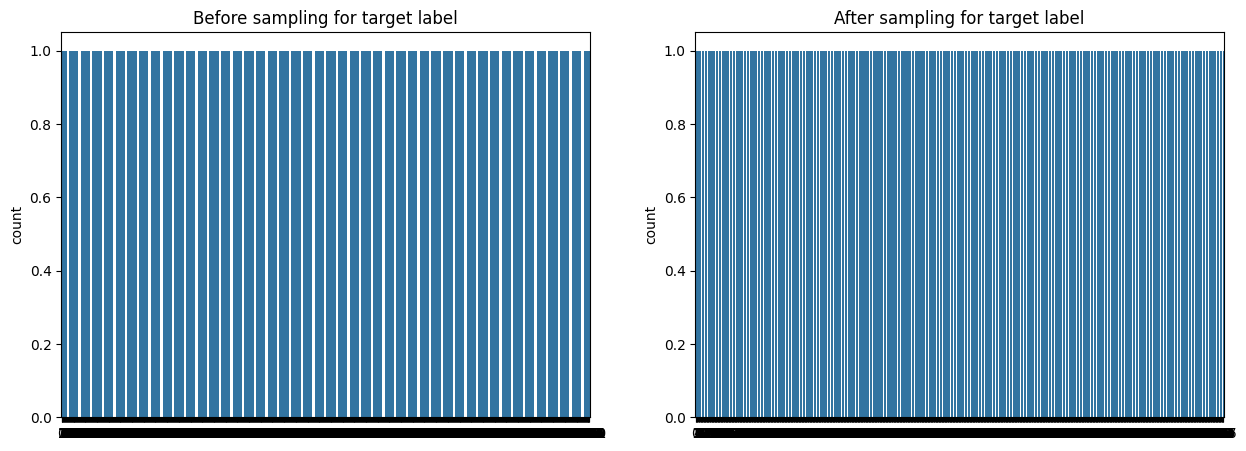

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
sns.countplot(y_fs_final_train)
plt.title("Before sampling for target label")

fig.add_subplot(122)
sns.countplot(y_sme_sampling)
plt.title("After sampling for target label")

### 3-3 Summary
##### 총 3개 유형의 feature를 생성 -> model optimization 실험
1.   No Feature Selection + No sampling (X_base, Y_encoded)
2.   Feature Selection (X_fs_final, Y_encoded)
3.   Feature Selection + Combined Sampling (X_fs_sme_sampling, y_sme_sampling / X_fs_final_validation, y_fs_final_validation)

  

## 4. Model Analysis
1.   base model (No Feature Selection + No sampling)
2.   ML with Feature Selection (No samping)
3.   ML with Feature selection and Combined Sampling
4.   ML with Feature Selection and No Combined Sampilng + Cost Sensitive Learning


In [ ]:
list_model_metric = []
cv = 3
n_jobs = -1

### 4-1. Base Model Learning

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y_encoded, test_size = 0.3, random_state = random_state)

In [ ]:
# 1. 모델 생성 (단일 모델)
# max_depth=4: 트리의 깊이를 4로 고정 (너무 깊지 않게 설정)
# n_estimators=5: 나무를 딱 5그루만 심겠다 (학습 반복 횟수 5회)
# 참고: n_estimators가 5면 실무적으로는 매우 적은 숫자입니다. (보통 100~1000 단위 사용)
# 테스트용이나 빠르게 결과를 보고 싶을 때 이렇게 적게 설정합니다.
xgb_clf = XGBClassifier(max_depth=4, n_estimators=5)

# 2. 모델 학습
# 준비된 훈련 데이터(X_train)와 정답(y_train)으로 모델을 학습시킵니다.
xgb_clf.fit(X_train, y_train)

# 3. 예측 (확률값 추출)
# 검증 데이터(X_validation)에 대해 예측을 수행합니다.
# [:,-1] : 앞서 설명드린 대로 '0(잔류)'일 확률은 버리고, '1(퇴사)'일 확률만 가져옵니다.
y_prd = xgb_clf.predict_proba(X_validation)[:, -1]

# 4. 성능 평가 (ROC-AUC)
# 실제 정답(y_validation)과 모델이 예측한 확률(y_prd)을 비교하여 점수를 매깁니다.
score = roc_auc_score(y_validation, y_prd)

# 5. 결과 출력
print("roc_auc_score : ", score)

# 6. 점수 저장
# 나중에 다른 모델들과 비교하기 위해 리스트에 점수를 추가합니다.
list_model_metric.append(score)

roc_auc_score :  0.7631497882171736


### 4-2. Optimization 1 :  ML with Feature Selection (No samping)

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_fs_final, Y_encoded, test_size = 0.3, random_state = random_state)

In [ ]:
# 1. 탐색할 하이퍼파라미터의 조합들을 딕셔너리 형태로 정의합니다.
# GridSearchCV는 이 리스트에 있는 값들의 모든 경우의 수(조합)를 다 시도해봅니다.
hyper_params_xgb = {
    "colsample_bytree": [0.8, 1.0],      # 트리를 만들 때 피처(컬럼)를 얼마나 샘플링할지 비율 (0.8 = 80%만 사용)
    "min_child_weight": [1.0, 1.2],      # 과적합 방지를 위한 파라미터 (값이 클수록 모델이 보수적이 됨)
    'max_depth': [4, 6, 8, 10],          # 트리의 최대 깊이 (깊을수록 모델이 복잡해짐)
    'n_estimators': [10, 15, 20, 25]     # 생성할 트리의 개수 (학습 반복 횟수)
}

# 2. XGBoost 분류기(Classifier) 객체를 생성합니다.
# (여기 들어간 인자들은 어차피 아래 GridSearchCV에서 위 딕셔너리 값으로 덮어씌워지므로 초기화용입니다.)
xgb_clf = XGBClassifier(max_depth=4, n_estimators=5)

# 3. GridSearchCV 객체를 생성합니다.
# xgb_clf: 학습시킬 모델
# param_grid: 시도해볼 파라미터 조합들 (위에서 정의한 hyper_params_xgb)
# cv: 교차 검증(Cross Validation) 횟수 (예: 5라면 데이터를 5조각 내서 검증)
# n_jobs: 병렬 처리에 사용할 CPU 코어 수 (-1이면 모든 코어 사용)
grid_cv_opt1 = GridSearchCV(xgb_clf, param_grid=hyper_params_xgb, cv=cv, n_jobs=n_jobs) # cross-validation: fold 3번

# 4. 그리드 서치를 수행합니다. (학습 시작)
# 정의된 모든 파라미터 조합으로 학습을 돌려보고, 그 중 가장 성능이 좋은 조합을 찾습니다.
grid_cv_opt1.fit(X_train, y_train)

# 5. 찾아낸 최고의 파라미터 조합을 출력합니다.
print('best model hyper-parameter : ', grid_cv_opt1.best_params_)

# 6. 최적의 모델(grid_cv_opt1)을 사용해 검증 데이터(X_validation)를 예측합니다.
# predict_proba: 결과가 0 또는 1이 아니라, [0일 확률, 1일 확률]로 나옵니다.
# [:, -1]: 그 중에서 '1(양성, 즉 퇴사할 확률)'에 해당하는 값만 가져옵니다. (ROC AUC 계산용)
y_prd = grid_cv_opt1.predict_proba(X_validation)[:, -1]

# 7. 성능 지표인 ROC-AUC Score를 계산합니다.
# y_validation: 실제 정답 / y_prd: 모델이 예측한 확률
score = roc_auc_score(y_validation, y_prd)

# 결과 점수 출력
print("roc_auc_score : ", score)

# 8. 나중에 다른 모델들과 점수를 비교하기 위해 리스트에 저장해둡니다.
list_model_metric.append(score)

best model hyper-parameter :  {'colsample_bytree': 0.8, 'max_depth': 10, 'min_child_weight': 1.2, 'n_estimators': 25}
roc_auc_score :  0.7772814786291876


### 4-3. Optimization 2 : ML with Feature selection and Combined Sampling

In [ ]:
# X_fs_sme_sampling, y_sme_sampling / X_fs_final_validation, y_fs_final_validation

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# 1. 하이퍼파라미터 그리드 설정 (이전과 동일)
hyper_params_xgb = {
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1.0, 1.2],
    'max_depth': [4, 6, 8, 10],
    'n_estimators': [10, 15, 20, 25]
}

# 2. XGBoost 분류기 객체 생성
xgb_clf = XGBClassifier(max_depth=4, n_estimators=5)

# 3. GridSearchCV 설정 (grid_cv_opt2: 두 번째 최적화 시도라는 의미로 보입니다)
grid_cv_opt2 = GridSearchCV(xgb_clf, param_grid=hyper_params_xgb, cv=cv, n_jobs=n_jobs)

# 4. 모델 학습 (★가장 중요한 차이점★)
# X_fs_sme_sampling:
#   - fs (Feature Selection): 의미 있는 컬럼만 추려낸 데이터
#   - sme (SMOTE 등): 데이터 불균형(Imbalance) 해결을 위해 오버샘플링된 데이터
# 즉, "정제되고 뻥튀기된 데이터"로 학습을 시켜 최적의 파라미터를 찾습니다.
grid_cv_opt2.fit(X_fs_sme_sampling, y_sme_sampling)

# 5. 최적 파라미터 출력
print('best model hyper-parameter : ', grid_cv_opt2.best_params_)

# 6. 검증 데이터로 예측 수행
# X_fs_final_validation:
#   - 학습 데이터와 똑같이 'Feature Selection(fs)' 처리가 된 최종 검증용 데이터입니다.
#   - 주의: 검증용 데이터에는 보통 SMOTE(뻥튀기)를 하지 않습니다. (현실 데이터와 같아야 하므로)
y_prd = grid_cv_opt2.predict_proba(X_fs_final_validation)[:, -1]

# 7. 성능 평가 (ROC-AUC)
score = roc_auc_score(y_fs_final_validation, y_prd)

# 결과 출력
print("roc_auc_score : ", score)

# 8. 점수 저장
list_model_metric.append(score)

best model hyper-parameter :  {'colsample_bytree': 0.8, 'max_depth': 8, 'min_child_weight': 1.0, 'n_estimators': 10}
roc_auc_score :  0.6803521474411716


### 4-4. Optimization 3 : ML with Feature Selection and No Combined Sampilng + Cost Sensitive Learning

In [ ]:
#from sklearn.utils import class_weight
#classes_weights = class_weight.compute_sample_weight(
##    class_weight='balanced',
#  y=train_df['class']
#)

#xgb_classifier.fit(X, y, sample_weight=classes_weights)

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_fs_final, Y_encoded, test_size = 0.3, random_state = random_state)

In [ ]:
# 1. 하이퍼파라미터 설정 (샘플 가중치 추가됨)
hyper_params_xgb = {
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1.0, 1.2],
    'max_depth': [4, 6, 8, 10],
    'n_estimators': [10, 15, 20, 25],

    # ★ 핵심 변화 부분 ★
    # compute_sample_weight("balanced", y_train):
    #   데이터의 클래스 비율(불균형)을 계산해서 역수를 취합니다.
    #   예: 퇴사자(Yes)가 적으면 퇴사자 데이터 하나하나에 더 큰 가중치(중요도)를 부여합니다.
    #   즉, "퇴사자를 못 맞추면 벌점을 더 크게 주겠다"는 설정을 파라미터에 포함시킨 것입니다.
    # (주의: 이 코드는 의도만 설명하며, 실제 실행 시 문법적 위치 수정이 필요할 수 있습니다. 아래 설명 참조)
    'sample_weight': compute_sample_weight("balanced", y_train)
}

# 2. 모델 객체 생성
xgb_clf = XGBClassifier(max_depth=4, n_estimators=5)

# 3. GridSearchCV 설정
# grid_cv_opt3: 세 번째 최적화 시도
grid_cv_opt3 = GridSearchCV(xgb_clf, param_grid=hyper_params_xgb, cv=cv, n_jobs=n_jobs)

# 4. 모델 학습
# 여기서는 SMOTE된 데이터(X_fs_sme...)가 아니라 "원본 학습 데이터(X_train)"를 씁니다.
# 대신 위에서 설정한 'sample_weight'가 내부적으로 작동하여 불균형을 보정하려고 시도합니다.
grid_cv_opt3.fit(X_train, y_train)

# 5. 최적 파라미터 출력
print('best model hyper-parameter : ', grid_cv_opt3.best_params_)

# 6. 예측 및 평가
# 검증 데이터(X_validation)로 예측을 수행합니다.
y_prd = grid_cv_opt3.predict_proba(X_validation)[:, -1]
score = roc_auc_score(y_validation, y_prd)

print("roc_auc_score : ", score)
list_model_metric.append(score)

best model hyper-parameter :  {'colsample_bytree': 0.8, 'max_depth': 10, 'min_child_weight': 1.2, 'n_estimators': 25, 'sample_weight': np.float64(0.5968677494199536)}
roc_auc_score :  0.7772814786291876


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:54:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "sample_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# 1. 결과 데이터프레임 생성
# 지금까지 list_model_metric에 모아둔 점수들을 모델 이름과 매칭시켜 표로 만듭니다.
df_metric = pd.DataFrame({
    'Model': ['basic', 'featue selection', 'feature selection and combinedsampling', 'feature selection and cost-sensitive learning'],
    'roc_auc_score': list_model_metric
})

# 2. 가로 막대 그래프 그리기 (Horizontal Bar Plot)
# barh: 모델 이름이 길기 때문에 세로 막대보다 가로 막대가 가독성이 훨씬 좋습니다.
ax = df_metric.plot.barh(x='Model', y='roc_auc_score', rot=0, figsize=(10, 5), legend=False)

# 3. 그래프 위에 점수 숫자 적기 (Annotation)
for bar in ax.patches:
    # bar.get_width(): 막대의 길이 (즉, 점수)
    # bar.get_y() + bar.get_height() / 2: 막대의 높이 중 정중앙 위치
    ax.annotate(format(bar.get_width(), '.4f'),  # 점수를 소수점 4째 자리까지 표시
                (bar.get_width(), bar.get_y() + bar.get_height() / 2), # 글씨 쓸 위치
                size=15, xytext=(8, 0),  # 글자 크기와 약간의 여백(offset)
                textcoords='offset points')

# cost-sensitive learning이 의미가 없음
# 이미 불균형중 minority 데이터 분포가 확실함